(必要モジュールをインポート、関数を定義、"./datasets/train/"から訓練用データセットを読み込む)

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] ='cm'
%matplotlib inline
np.random.seed(seed=1)

In [2]:
# ReLu関数を定義
def Relu(x):
    return np.maximum(0.0, x)

In [7]:
# グラフデータとラベルデータを格納する配列を定義
graph_data = []
label_data = []

# テキストファイルの読み込み
for i in range(2000):
    path = './datasets/train/' + str(i) + '_label.txt'
    file_data = open(path, "r")
    for line in file_data:
        temp = line.strip()
        temp = temp.split()
        label_data.append(int(temp[0]))
    file_data.close()
        
    graph_temp = []
    D = 0
    path = './datasets/train/' + str(i) + '_graph.txt' 
    file_data = open(path, "r")
    for line in file_data:
        temp = line.strip()
        temp = temp.split()
        if (len(temp)==1):
            D = int(temp[0])
        if (len(temp)!=1):
            for j in range(D):
                graph_temp.append(int(temp[j]))
    file_data.close()
    graph_temp = np.array(graph_temp).reshape(D,D)
    graph_data.append(graph_temp)

# 課題1

(グラフデータ,初期特徴ベクトル集合)が与えられた場合に、集約繰り返しとReadoutによって得られる特徴ベクトルを計算するGNNを実装する。

In [3]:
# GNNクラス
class GNN_Problem1:
    
    def __init__(self):
        # 集約step数 T, 特徴ベクトル次元 D の設定
        self.T = 2
        self.D = 8
        
        # ハイパーパラメータの設定 (Wはランダムサンプリングfrom正規分布)
        self.W = np.random.normal(0.0,0.4,(self.D,self.D))
        
    
    # 特徴量ベクトルh_Gを作成するFeature_vec関数。引数としてグラフデータG(隣接行列形式)と初期特徴ベクトル集合vecを与える。
    def Feature_vec(self, G, vec):
        
        # 1ステップの集約操作を行うCombine関数、Readout操作を行うReadout関数を定義
        def Combine(G, vec):
            A = np.empty((0,self.D), float)
            for i in range(len(G)):
                # 集約-1
                a = np.array([0.0 for k in range(self.D)])
                for j in range(len(G)):
                    a += G[i][j]*vec[j]
                # 集約-2
                x = Relu(np.dot(self.W,a))
                # 次の特徴ベクトル集合にappend
                A = np.append(A, [x], axis=0)
            return A
        
        def Readout(V):
            h_G = np.zeros(len(V[0]))
            for i in range(len(V)):
                h_G += V[i]
            return h_G
        
        # T回のCombine関数実行後、Readout関数で和を取る
        for step in range(self.T):
            vec = Combine(G, vec)
        return Readout(vec)

In [4]:
## テスト計算 ##

# まずGNNクラスのインスタンス生成
n = GNN_Problem1()


# --------------ハイパーパラメータ等を設定--------------

n.T = 1
n.D = 5
n.W = np.array([[1,0,0,0,0],
                [0,1,0,0,0],
                [0,0,1,0,0],
                [0,0,0,1,0],
                [0,0,0,0,1]], dtype=float)

G = np.array([[0,1,0,0],
              [1,0,1,1],
              [0,1,0,1],
              [0,1,1,0]])

vec = np.array([[1,0,0,0,0],
                [0,1,0,0,0],
                [0,0,1,0,0],
                [0,0,0,1,0]], dtype=float)

# --------------ハイパーパラメータ等を設定--------------


# 最後にFeature_vec関数を実行、返り値が求める特徴ベクトル
n.Feature_vec(G, vec)

array([1., 3., 2., 2., 0.])

# 課題2

In [5]:
class GNN_Problem2:
    
    def __init__(self, alpha, epsilon):
        # 集約step数 T, 特徴ベクトル次元 D の設定
        self.T = 2
        self.D = 8
        
        # ハイパーパラメータの設定 (W,Aはランダムサンプリングfrom正規分布)
        self.W = np.random.normal(0.0,0.4,(self.D,self.D))
        self.A = np.random.normal(0.0,0.4,self.D)
        self.b = 0.0
        
        # 微分計算用の微小量 ε
        self.epsilon = epsilon
        # 学習率 α
        self.alpha = alpha
        

    # 特徴量ベクトルh_Gを作成するFeature_vec関数。引数としてグラフデータG(隣接行列形式)と初期特徴ベクトル集合vecを与える。
    def Feature_vec(self, G, vec):
        
        # 1ステップの集約操作を行うCombine関数、Readout操作を行うReadout関数を定義
        def Combine(G, vec):
            A = np.empty((0,self.D), float)
            for i in range(len(G)):
                # 集約-1
                a = np.array([0.0 for k in range(self.D)])
                for j in range(len(G)):
                    a += G[i][j]*vec[j]
                # 集約-2
                x = Relu(np.dot(self.W,a))
                # 次の特徴ベクトル集合にappend
                A = np.append(A, [x], axis=0)
            return A
        
        def Readout(V):
            h_G = np.zeros(len(V[0]))
            for i in range(len(V)):
                h_G += V[i]
            return h_G
        
        # T回のCombine関数実行後、Readout関数で和を取る
        for step in range(self.T):
            vec = Combine(G, vec)
        return Readout(vec)
    
    
    # 誤差関数
    def Loss(self, G, y, vec):
        # まずFeature_vec関数から特徴ベクトルh_Gを生成。
        h_G = self.Feature_vec(G, vec)
        
        # ラベルyとの差分からbinary cross-entropy損失関数を計算
        s = np.dot(self.A, h_G) + self.b  # s = A・h_G + b
        if (s>=40):                       # sの絶対値が大きい場合は log(1+e^s) ~ s で近似
            L = (1-y)*s
        elif (s<=-40):
            L = y*(-s)
        else:
            L = y*math.log(1+math.exp(-s)) + (1-y)*math.log(1+math.exp(s))
        return L

        
    # (input,label)のデータ集合に対してLoss関数の微分値平均計算、それに基づいてハイパーパラメータを更新する
    def train(self, input_list, label_list):
        # 配列・変数の初期化
        mean_diff_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        mean_diff_A = np.array([0.0 for i in range(len(self.A))])
        mean_diff_b = 0.0
        
        # 各(input,label)についてLossと微分値計算
        for index in range(len(input_list)):
            
            # 1つの(graph,label)についてLossと微分値計算
            graph = input_list[index]
            y = label_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            print("Loss :", L_now)
            
            # 損失関数の微分値計算 δL/δθ = (L(G,y,θ+εδ_i)-L(G,y,θ)) / ε
            # Wについて
            diff_W = []
            for j in range(self.D):
                for k in range(self.D):
                    self.W[j][k] += 1.0*self.epsilon
                    diff_W.append(self.Loss(graph, y, vec) - L_now)
                    self.W[j][k] -= 1.0*self.epsilon
            diff_W = np.array(diff_W).reshape(self.D, self.D)
            mean_diff_W += diff_W
            
            # Aについて
            diff_A = []
            for i in range(len(self.A)):
                self.A[i] += 1.0*self.epsilon
                diff_A.append(self.Loss(graph, y, vec) - L_now)
                self.A[i] -= 1.0*self.epsilon
            diff_A = np.array(diff_A)
            mean_diff_A += diff_A
                
            # bについて
            self.b += 1.0*self.epsilon
            diff_b = self.Loss(graph, y, vec) - L_now
            self.b -= 1.0*self.epsilon
            mean_diff_b += diff_b
            
        # 損失Lの微分値平均を取る : δL/δθ
        mean_diff_W /= len(input_list)*self.epsilon
        mean_diff_A /= len(input_list)*self.epsilon
        mean_diff_b /= len(input_list)*self.epsilon
        
        # パラメータ更新 : -α*δL/δθ
        self.W += -self.alpha*mean_diff_W
        self.A += -self.alpha*mean_diff_A
        self.b += -self.alpha*mean_diff_b

In [6]:
alpha = 0.01    
epsilon = 0.001

# GNNのインスタンス生成
n = GNN_Problem2(alpha, epsilon)

# inputデータの設定(グラフ構造,ラベル)
graph = np.array([[[0,1,0,0,0,0,0,0,0,0,1],
                   [1,0,0,0,0,0,0,0,0,1,0],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,0,0,0,0,0,0],
                   [0,0,0,1,0,0,0,0,0,1,0],
                   [0,0,0,0,0,0,0,0,1,0,1],
                   [0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,1],
                   [0,0,0,0,0,1,0,0,0,0,0],
                   [0,1,0,0,1,0,0,0,0,0,1],
                   [1,0,0,0,0,1,0,1,0,1,0]]])
label = np.array([0])

# train関数で損失Lが減少する
for i in range(20):
    n.train(graph, label)

Loss : 0.37401704747681336
Loss : 0.24014785799430466
Loss : 0.17066578476496755
Loss : 0.13090942517408072
Loss : 0.10552610997000648
Loss : 0.08802665052773305
Loss : 0.07528335799162207
Loss : 0.06561642313192657
Loss : 0.05804763528028642
Loss : 0.05197061479304442
Loss : 0.04699034811065252
Loss : 0.04283891967803772
Loss : 0.03932844272580709
Loss : 0.036323395095966916
Loss : 0.03372365065855265
Loss : 0.03145368599020162
Loss : 0.029455496739516692
Loss : 0.027683820298661475
Loss : 0.026102835901788825
Loss : 0.024683836472850582


# 課題3

### GNN_SGDクラスを定義 
- 課題2のGNNクラスに、学習後のハイパーパラメータにおける損失Lと正答率を計算するtest関数を追加

In [104]:
class GNN_SGD:
    
    def __init__(self, alpha, epsilon):
        # 集約step数 T, 特徴ベクトル次元 D の設定
        self.T = 2
        self.D = 8
        
        # ハイパーパラメータの設定 (W,Aはランダムサンプリングfrom正規分布)
        self.W = np.random.normal(0.0,0.4,(self.D,self.D))
        self.A = np.random.normal(0.0,0.4,self.D)
        self.b = 0.0
        
        # 微分計算用の微小量 ε
        self.epsilon = epsilon
        # 学習率 α
        self.alpha = alpha
        

    # 特徴量ベクトルh_Gを作成するFeature_vec関数。引数としてグラフデータG(隣接行列形式)と初期特徴ベクトル集合vecを与える。
    def Feature_vec(self, G, vec):
        
        # 1ステップの集約操作を行うCombine関数、Readout操作を行うReadout関数を定義
        def Combine(G, vec):
            A = np.empty((0,self.D), float)
            for i in range(len(G)):
                # 集約-1
                a = np.array([0.0 for k in range(self.D)])
                for j in range(len(G)):
                    a += G[i][j]*vec[j]
                # 集約-2
                x = Relu(np.dot(self.W,a))
                # 次の特徴ベクトル集合にappend
                A = np.append(A, [x], axis=0)
            return A
        
        def Readout(V):
            h_G = np.zeros(len(V[0]))
            for i in range(len(V)):
                h_G += V[i]
            return h_G
        
        # T回のCombine関数実行後、Readout関数で和を取る
        for step in range(self.T):
            vec = Combine(G, vec)
        return Readout(vec)
    
    
    # 誤差関数
    def Loss(self, G, y, vec):
        # まずFeature_vec関数から特徴ベクトルh_Gを生成。
        h_G = self.Feature_vec(G, vec)
        
        # ラベルyとの差分からbinary cross-entropy損失関数を計算
        s = np.dot(self.A, h_G) + self.b  # s = A・h_G + b
        if (s>=40):                       # sの絶対値が大きい場合は log(1+e^s) ~ s で近似
            L = (1-y)*s
        elif (s<=-40):
            L = y*(-s)
        else:
            L = y*math.log(1+math.exp(-s)) + (1-y)*math.log(1+math.exp(s))
        return L

        
    # (input,label)のデータ集合に対してLoss関数の微分値平均計算、それに基づいてハイパーパラメータを更新する
    def train(self, input_list, label_list):
        # 配列・変数の初期化
        mean_diff_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        mean_diff_A = np.array([0.0 for i in range(len(self.A))])
        mean_diff_b = 0.0
        
        # 各(input,label)についてLossと微分値計算
        for index in range(len(input_list)):
            
            # 1つの(graph,label)についてLossと微分値計算
            graph = input_list[index]
            y = label_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            
            # 損失関数の微分値計算 δL/δθ = (L(G,y,θ+εδ_i)-L(G,y,θ)) / ε
            # Wについて
            diff_W = []
            for j in range(self.D):
                for k in range(self.D):
                    self.W[j][k] += 1.0*self.epsilon
                    diff_W.append(self.Loss(graph, y, vec) - L_now)
                    self.W[j][k] -= 1.0*self.epsilon
            diff_W = np.array(diff_W).reshape(self.D, self.D)
            mean_diff_W += diff_W
            
            # Aについて
            diff_A = []
            for i in range(len(self.A)):
                self.A[i] += 1.0*self.epsilon
                diff_A.append(self.Loss(graph, y, vec) - L_now)
                self.A[i] -= 1.0*self.epsilon
            diff_A = np.array(diff_A)
            mean_diff_A += diff_A
                
            # bについて
            self.b += 1.0*self.epsilon
            diff_b = self.Loss(graph, y, vec) - L_now
            self.b -= 1.0*self.epsilon
            mean_diff_b += diff_b
            
        # 損失Lの微分値平均を取る : δL/δθ
        mean_diff_W /= len(input_list)*self.epsilon
        mean_diff_A /= len(input_list)*self.epsilon
        mean_diff_b /= len(input_list)*self.epsilon
        
        # パラメータ更新 : -α*δL/δθ
        self.W += -self.alpha*mean_diff_W
        self.A += -self.alpha*mean_diff_A
        self.b += -self.alpha*mean_diff_b
        
        
    def test(self, input_list, label_list):
        # 配列の初期化
        Loss_list = []
        s_list = []
        
        # 各(input,label)についてLoss計算
        for index in range(len(input_list)):
            graph = input_list[index]
            y = label_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            Loss_list.append(L_now)
            
            # s値計算
            s_list.append(np.dot(self.A, self.Feature_vec(graph, vec)) + self.b)

        
        # 平均損失と正答率を計算
        true = 0
        for i in range(len(input_list)):
            #print(s_list[i], label_list[i])
            if (s_list[i]>0.0 and label_list[i]==1):
                true += 1
            elif (s_list[i]<=0.0 and label_list[i]==0):
                true += 1
        true /= float(len(input_list))
        Loss_list = np.array(Loss_list)
        return np.mean(Loss_list), true

### GNN_MomentumSGDクラスを定義 
- GNN_SGDクラスに、ハイパーパラメータ更新の際に慣性項を考慮する処理を追加

In [105]:
class GNN_MomentumSGD:
    
    def __init__(self, alpha, epsilon):
        # 集約step数 T, 特徴ベクトル次元 D の設定
        self.T = 2
        self.D = 8
        
        # ハイパーパラメータの設定 (W,Aはランダムサンプリングfrom正規分布)
        self.W = np.random.normal(0.0,0.4,(self.D,self.D))
        self.A = np.random.normal(0.0,0.4,self.D)
        self.b = 0.0
        
        # 前回のハイパーパラメータ更新幅
        self.prev_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        self.prev_A = np.array([0.0 for i in range(len(self.A))])
        self.prev_b = 0.0
        
        # 微分計算用の微小量 ε
        self.epsilon = epsilon
        # 学習率 α
        self.alpha = alpha
        # 慣性項
        self.eta = eta
        

    # 特徴量ベクトルh_Gを作成するFeature_vec関数。引数としてグラフデータG(隣接行列形式)と初期特徴ベクトル集合vecを与える。
    def Feature_vec(self, G, vec):
        
        # 1ステップの集約操作を行うCombine関数、Readout操作を行うReadout関数を定義
        def Combine(G, vec):
            A = np.empty((0,self.D), float)
            for i in range(len(G)):
                # 集約-1
                a = np.array([0.0 for k in range(self.D)])
                for j in range(len(G)):
                    a += G[i][j]*vec[j]
                # 集約-2
                x = Relu(np.dot(self.W,a))
                # 次の特徴ベクトル集合にappend
                A = np.append(A, [x], axis=0)
            return A
        
        def Readout(V):
            h_G = np.zeros(len(V[0]))
            for i in range(len(V)):
                h_G += V[i]
            return h_G
        
        # T回のCombine関数実行後、Readout関数で和を取る
        for step in range(self.T):
            vec = Combine(G, vec)
        return Readout(vec)
    
    
    # 誤差関数
    def Loss(self, G, y, vec):
        # まずFeature_vec関数から特徴ベクトルh_Gを生成。
        h_G = self.Feature_vec(G, vec)
        
        # ラベルyとの差分からbinary cross-entropy損失関数を計算
        s = np.dot(self.A, h_G) + self.b  # s = A・h_G + b
        if (s>=40):                       # sの絶対値が大きい場合は log(1+e^s) ~ s で近似
            L = (1-y)*s
        elif (s<=-40):
            L = y*(-s)
        else:
            L = y*math.log(1+math.exp(-s)) + (1-y)*math.log(1+math.exp(s))
        return L

        
    # ミニバッチサイズB個の(input,label)に対してLoss関数の微分値平均計算、Hyperparametersを更新する
    def train(self, input_list, label_list):
        # 配列の初期化
        mean_diff_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        mean_diff_A = np.array([0.0 for i in range(len(self.A))])
        mean_diff_b = 0.0
        
        # 各(input,label)についてLossと微分値計算
        for index in range(len(input_list)):
            graph = input_list[index]
            y = label_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            #print(L_now)
            
            # Loss微分値計算
            # Wについて
            diff_W = []
            for j in range(self.D):
                for k in range(self.D):
                    self.W[j][k] += 1.0*self.epsilon
                    diff_W.append(self.Loss(graph, y, vec) - L_now)
                    self.W[j][k] -= 1.0*self.epsilon
            diff_W = np.array(diff_W).reshape(self.D, self.D)
            mean_diff_W += diff_W
            
            # Aについて
            diff_A = []
            for i in range(len(self.A)):
                self.A[i] += 1.0*self.epsilon
                diff_A.append(self.Loss(graph, y, vec) - L_now)
                self.A[i] -= 1.0*self.epsilon
            diff_A = np.array(diff_A)
            mean_diff_A += diff_A
                
            # bについて
            self.b += 1.0*self.epsilon
            diff_b = self.Loss(graph, y, vec) - L_now
            self.b -= 1.0*self.epsilon
            mean_diff_b += diff_b
            
        # Loss微分の平均取る
        mean_diff_W /= len(input_list)
        mean_diff_A /= len(input_list)
        mean_diff_b /= len(input_list)
        
        # パラメータ更新
        self.W += -self.alpha*mean_diff_W/self.epsilon + self.eta*self.prev_W
        self.A += -self.alpha*mean_diff_A/self.epsilon + self.eta*self.prev_A
        self.b += -self.alpha*mean_diff_b/self.epsilon + self.eta*self.prev_b
        
        # 前回Δθを更新
        self.prev_W = -self.alpha*mean_diff_W/self.epsilon + self.eta*self.prev_W
        self.prev_A = -self.alpha*mean_diff_A/self.epsilon + self.eta*self.prev_A
        self.prev_b = -self.alpha*mean_diff_b/self.epsilon + self.eta*self.prev_b
        
        
    def test(self, input_list, label_list):
        # 配列の初期化
        Loss_list = []
        s_list = []
        
        # 各(input,label)についてLoss計算
        for index in range(len(input_list)):
            graph = input_list[index]
            y = label_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            Loss_list.append(L_now)
            
            # s値計算
            s_list.append(np.dot(self.A, self.Feature_vec(graph, vec)) + self.b)

        
        # 平均損失と正答率を計算
        true = 0
        for i in range(len(input_list)):
            #print(s_list[i], label_list[i])
            if (s_list[i]>0.0 and label_list[i]==1):
                true += 1
            elif (s_list[i]<=0.0 and label_list[i]==0):
                true += 1
        true /= float(len(input_list))
        Loss_list = np.array(Loss_list)
        return np.mean(Loss_list), true

### 学習を行うLearning関数

In [106]:
# GNNのインスタンスnに対して、train,test,出力を行う
def Learning(n, flag):
    # エポック数 epochs、ミニバッチサイズ B、訓練データサイズ(検証データサイズ) の設定
    epochs = 50
    B = 10
    datasize_train = 1000
    datasize_test = 2000 - datasize_train
    
    # 結果保持用の配列を初期化
    result_train_loss = []
    result_train_accuracy = []
    result_test_loss = []
    result_test_accuracy = []
    
    # まずは学習前に損失Lと正答率を計算
    temp_loss, temp_accuracy = n.test(graph_data[0:datasize_train], label_data[0:datasize_train])
    result_train_loss.append(temp_loss)
    result_train_accuracy.append(temp_accuracy)
    temp_loss, temp_accuracy = n.test(graph_data[datasize_train:2000], label_data[datasize_train:2000])
    result_test_loss.append(temp_loss)
    result_test_accuracy.append(temp_accuracy)
    print("          (訓練データ)                       (テストデータ)")
    print("平均ロス : {:.3f}".format(result_train_loss[-1]), "正答率 : {:.3f}".format(result_train_accuracy[-1]), ",     平均ロス : {:.3f}".format(temp_loss), "正答率 : {:.3f}".format(temp_accuracy))
    
    # 学習開始
    for epoch in range(epochs):
        # 訓練データをB個ずつのミニバッチにランダム分割
        random_list = np.array([i for i in range(datasize_train)])
        np.random.shuffle(random_list)
        random_list = random_list.reshape(int(datasize_train/B),B)
        
        # 1epochの学習を行う
        for i in range(int(datasize_train/B)):
            mini_batch_graph = []
            mini_batch_label = []
            for j in range(B):
                mini_batch_graph.append(graph_data[random_list[i][j]])
                mini_batch_label.append(label_data[random_list[i][j]])
            n.train(mini_batch_graph, mini_batch_label)
            
        # 学習後の損失Lと正答率を計算
        temp_loss, temp_accuracy = n.test(graph_data[0:datasize_train], label_data[0:datasize_train])
        result_train_loss.append(temp_loss)
        result_train_accuracy.append(temp_accuracy)
        temp_loss, temp_accuracy = n.test(graph_data[datasize_train:2000], label_data[datasize_train:2000])
        result_test_loss.append(temp_loss)
        result_test_accuracy.append(temp_accuracy)
        print("平均ロス : {:.3f}".format(result_train_loss[-1]), "正答率 : {:.3f}".format(result_train_accuracy[-1]), ",     平均ロス : {:.3f}".format(temp_loss), "正答率 : {:.3f}".format(temp_accuracy))
        
    # ファイル出力
    if (flag==0):
        path = './outputs/GNN_SGD/'
    elif (flag==1):
        path = './outputs/GNN_MomentumSGD/'
        
    with open(path+'Loss_train.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_train_loss[i]))
            aa.write("\n")
    with open(path+'Loss_test.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_test_loss[i]))
            aa.write("\n")
    with open(path+'Accuracy_train.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_train_accuracy[i]))
            aa.write("\n")
    with open(path+'Accuracy_test.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_test_accuracy[i]))
            aa.write("\n")
    with open(path+'Hyperparmeters.txt', mode='w') as aa:
        for i in range(len(n.W)):
            for j in range(len(n.W[i])):
                aa.write(str(n.W[i][j]) + " ")
            aa.write("\n")
        for i in range(len(n.A)):
            aa.write(str(n.A[i]) + " ")
        aa.write("\n")
        aa. write(str(n.b))
    
    # 作図プロット
    plt.figure(dpi=600)
    plt.xlabel("Epochs",fontsize=15)
    plt.title('Loss $\it{L}$',loc='center',fontsize=25)
    plt.plot(result_train_loss,'o-',label="Train")
    plt.plot(result_test_loss,'o-', label="Test")
    plt.legend()
    plt.show()
    
    plt.figure(dpi=600)
    plt.xlabel("Epochs",fontsize=15)
    plt.title('Accuracy',loc='center',fontsize=25)
    plt.plot(result_train_accuracy,'o-',label="Train")
    plt.plot(result_test_accuracy,'o-', label="Test")
    plt.legend()
    plt.show()

## GNN_SGDを実行

          (訓練データ)                       (テストデータ)
平均ロス : 0.851 正答率 : 0.474 ,     平均ロス : 0.896 正答率 : 0.466
平均ロス : 0.801 正答率 : 0.476 ,     平均ロス : 0.839 正答率 : 0.466
平均ロス : 0.767 正答率 : 0.490 ,     平均ロス : 0.802 正答率 : 0.461
平均ロス : 0.744 正答率 : 0.487 ,     平均ロス : 0.770 正答率 : 0.471
平均ロス : 0.727 正答率 : 0.493 ,     平均ロス : 0.753 正答率 : 0.457
平均ロス : 0.715 正答率 : 0.498 ,     平均ロス : 0.740 正答率 : 0.479
平均ロス : 0.706 正答率 : 0.496 ,     平均ロス : 0.725 正答率 : 0.492
平均ロス : 0.700 正答率 : 0.506 ,     平均ロス : 0.722 正答率 : 0.488
平均ロス : 0.695 正答率 : 0.508 ,     平均ロス : 0.713 正答率 : 0.505
平均ロス : 0.692 正答率 : 0.509 ,     平均ロス : 0.710 正答率 : 0.495
平均ロス : 0.690 正答率 : 0.506 ,     平均ロス : 0.707 正答率 : 0.488
平均ロス : 0.687 正答率 : 0.517 ,     平均ロス : 0.703 正答率 : 0.489
平均ロス : 0.685 正答率 : 0.519 ,     平均ロス : 0.701 正答率 : 0.488
平均ロス : 0.684 正答率 : 0.533 ,     平均ロス : 0.698 正答率 : 0.501
平均ロス : 0.682 正答率 : 0.540 ,     平均ロス : 0.697 正答率 : 0.496
平均ロス : 0.682 正答率 : 0.547 ,     平均ロス : 0.693 正答率 : 0.521
平均ロス : 0.680 正答率 : 0.545 ,     平均ロス : 0.694 正答率 : 0.505

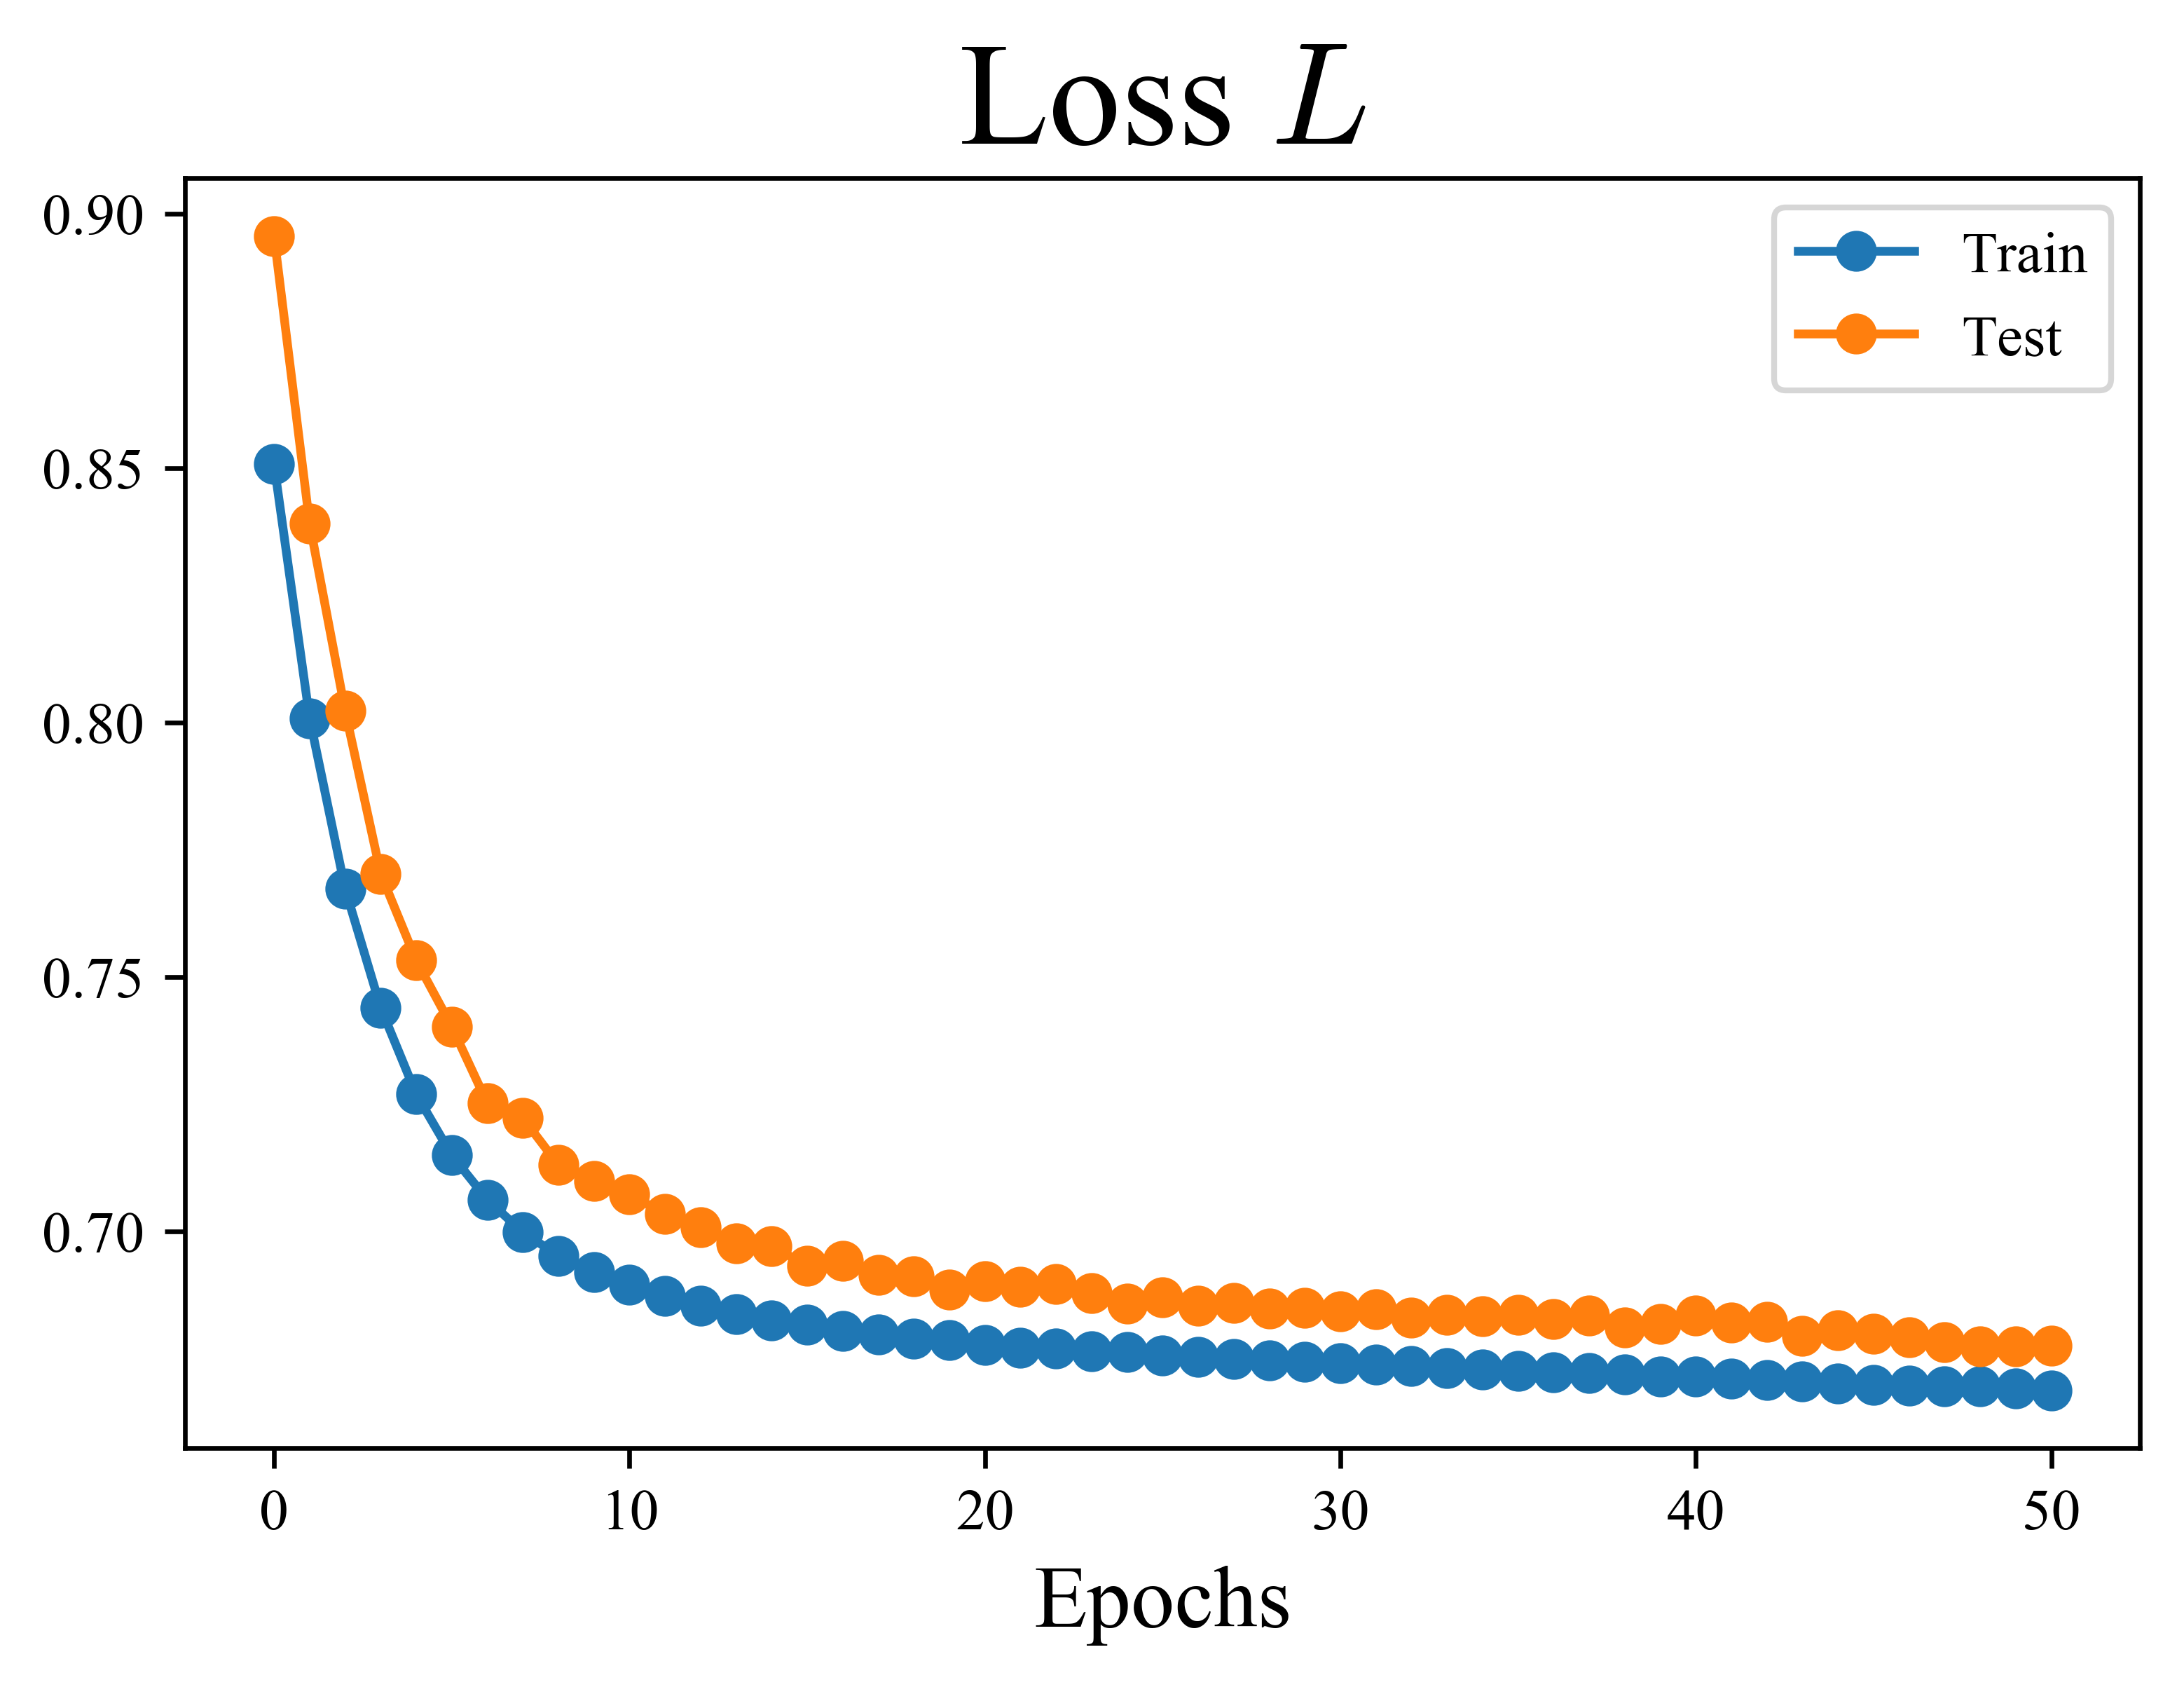

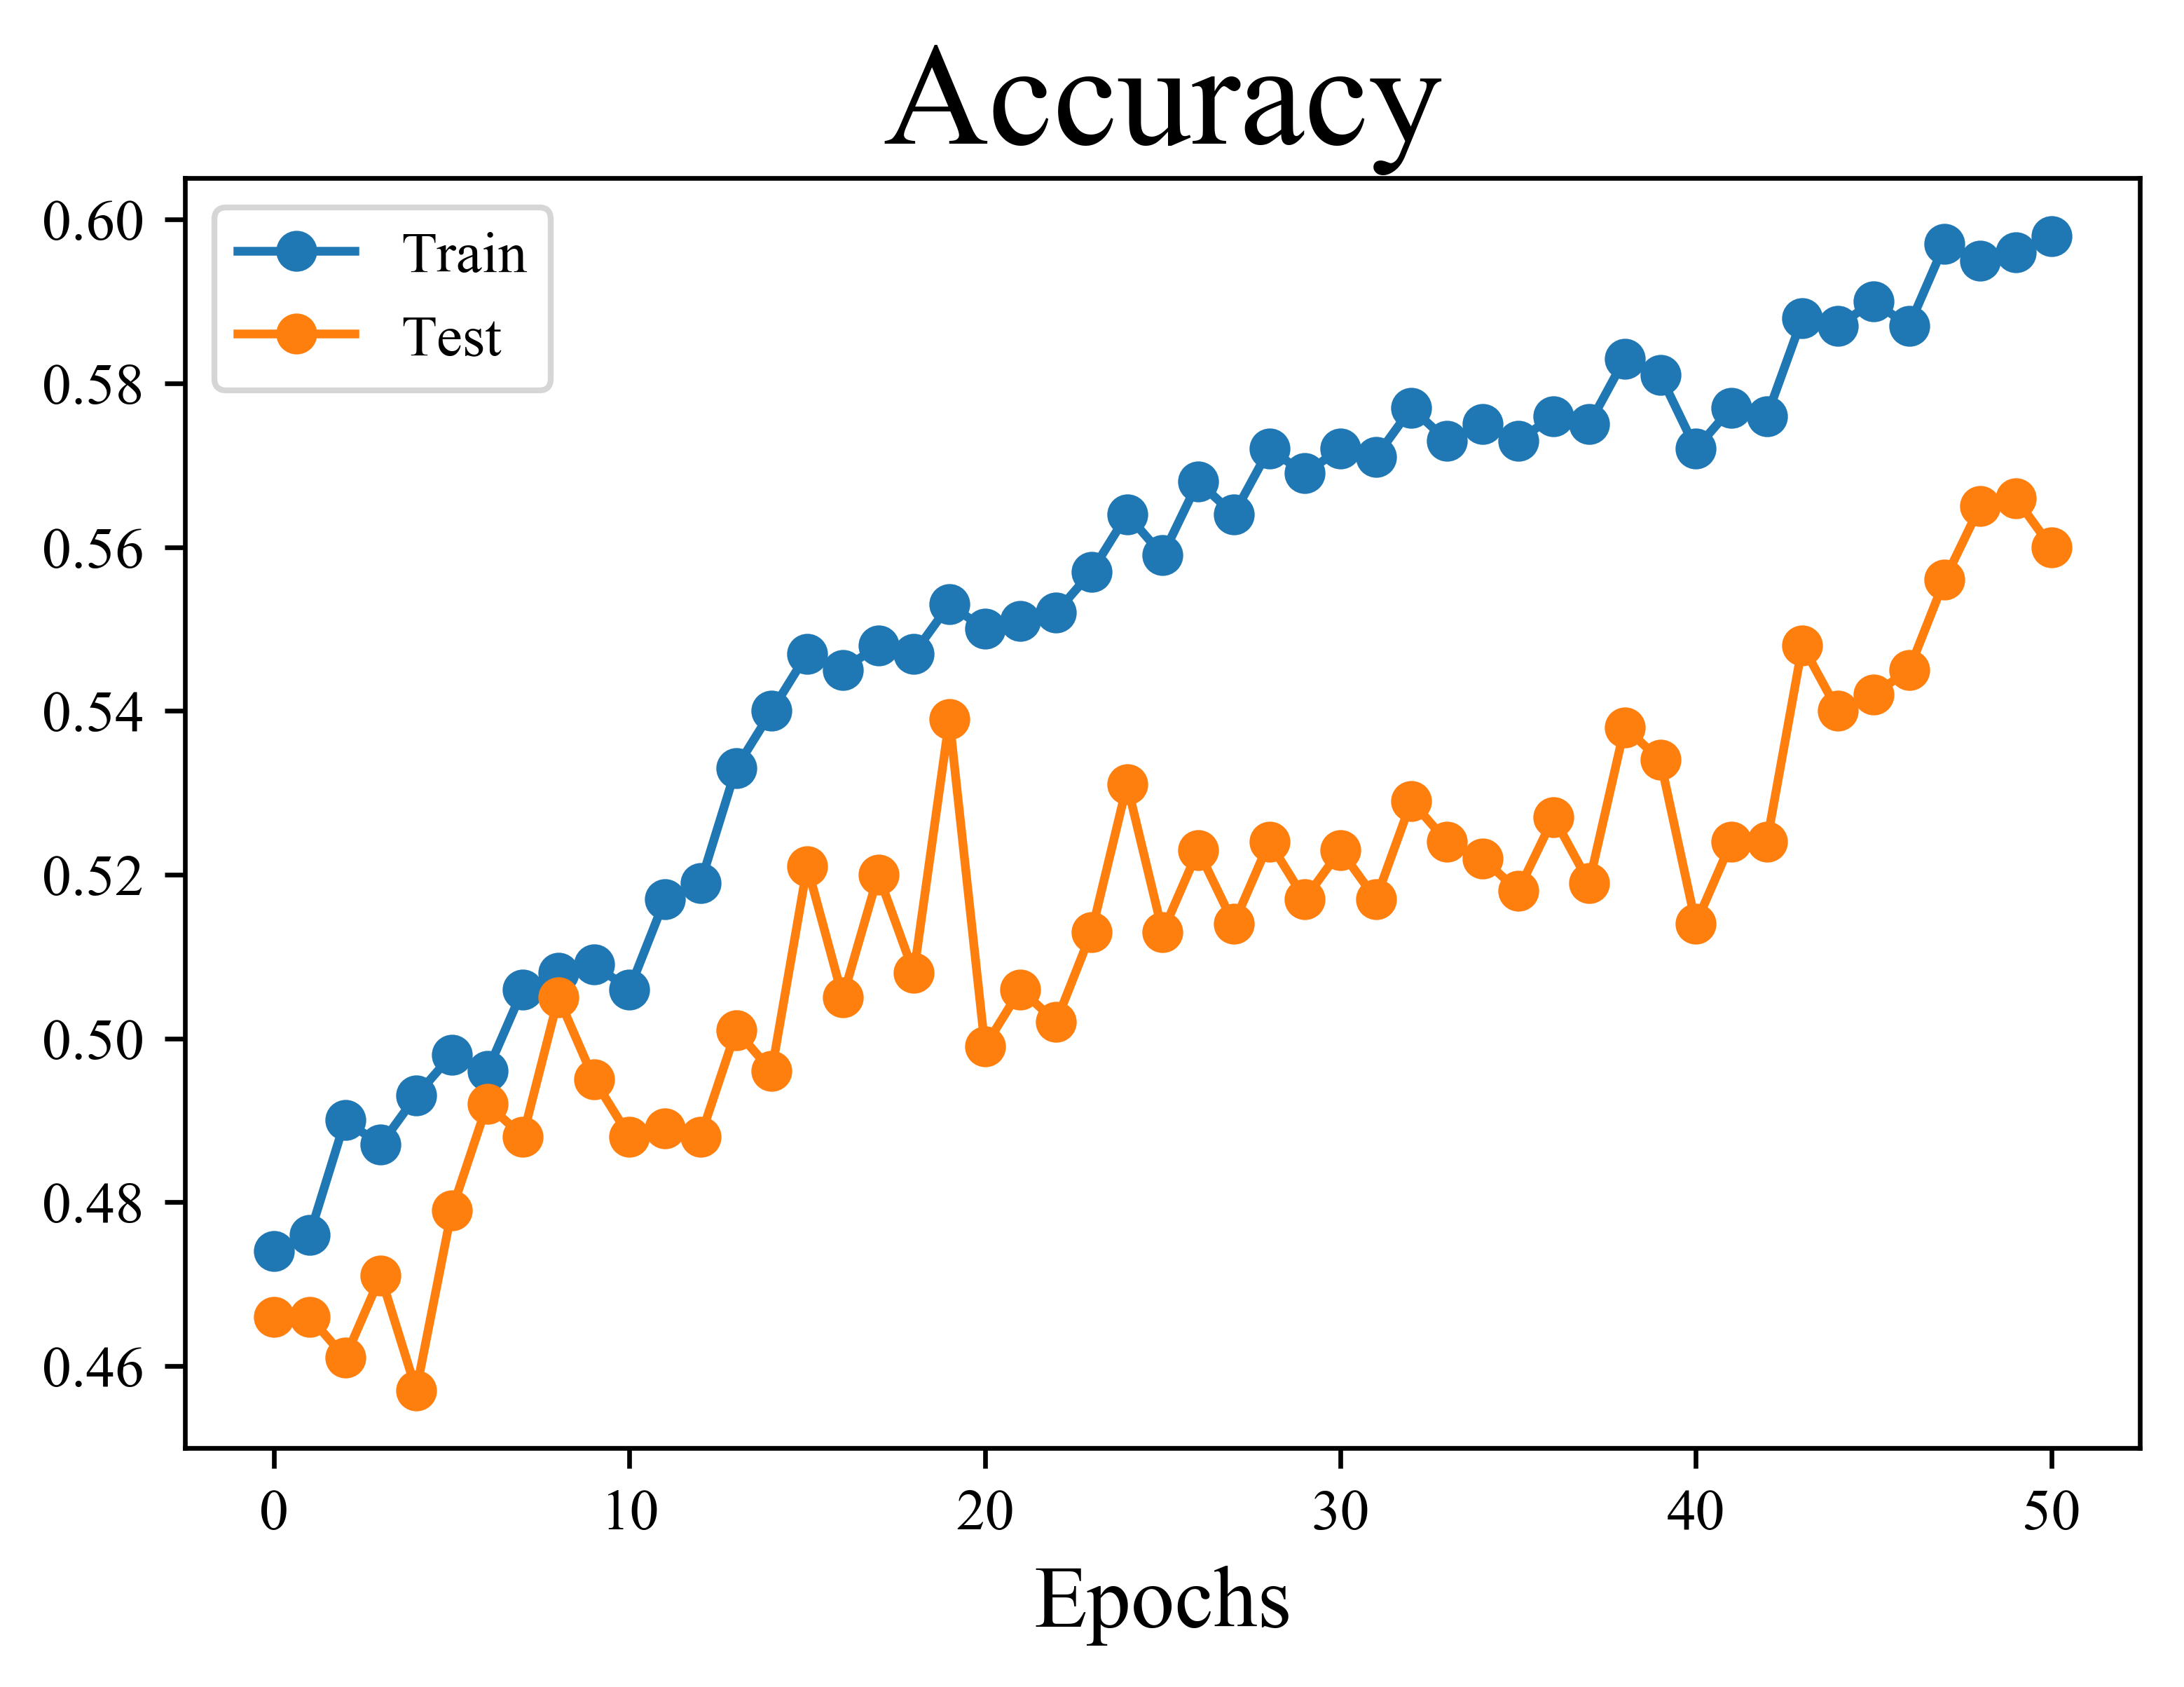

In [107]:
epsilon = 0.001
alpha = 0.001

# GNNのインスタンス生成
n_0 = GNN_SGD(alpha, epsilon)
n_0.W = np.array([[-2.52692808e-03,  2.92991035e-02,  5.67734735e-01, -4.25723553e-01, -1.36768259e-01, -3.61743362e-01, -8.17870662e-02,  3.73247119e-01],
                  [1.31089595e-02,  9.86127673e-02,  5.63567778e-05,  2.57001919e-01, 8.29995460e-01, -2.61330477e-01, -1.25492834e-01,  7.98894435e-02],
                  [-3.95713567e-01, -6.76726032e-01, -4.70752429e-01,  1.08178818e-01, -1.54971447e-01,  8.49478508e-01,  3.46967387e-02,  2.60424736e-01],
                  [-1.87265862e-01,  2.91553243e-01, -3.57373077e-01,  3.61584655e-01, -6.34358457e-02, -4.10927688e-01, -1.79272445e-01, -1.05599351e-01],
                  [-9.44209006e-01, -3.66578331e-01,  2.55020317e-01, -4.91308328e-01, 4.77561246e-01, -2.94744515e-01,  3.40336933e-03, -4.74844518e-01],
                  [3.83720321e-02, -1.00053689e+00, -3.29523178e-01,  1.61176760e-01,  4.60662881e-01, -6.40903355e-01, -6.35938286e-01,  2.99949703e-01],
                  [9.41320367e-01,  3.71874538e-01, -1.42864456e-01,  1.68296016e-01, -1.36711930e-01, -1.13083437e-01,  1.04520881e-01, -2.82616428e-01],
                  [2.84867666e-01,  1.03741936e-01, -5.12851503e-01,  7.65731388e-01, -1.25117393e-01,  5.74013842e-01, -2.61588672e-01, -3.66174601e-01]])
n_0.A = np.array([0.26510168, -0.01441418, 0.60813924, -0.16606723, -0.14615845, 0.0454674, -0.1699852, 0.00942905])

# 学習開始
Learning(n_0, flag=0)

## GNN_MomentumSGDを実行

          (訓練データ)                       (テストデータ)
平均ロス : 0.851 正答率 : 0.474 ,     平均ロス : 0.896 正答率 : 0.466
平均ロス : 0.686 正答率 : 0.524 ,     平均ロス : 0.698 正答率 : 0.507
平均ロス : 0.688 正答率 : 0.525 ,     平均ロス : 0.707 正答率 : 0.481
平均ロス : 0.685 正答率 : 0.528 ,     平均ロス : 0.705 正答率 : 0.482
平均ロス : 0.672 正答率 : 0.578 ,     平均ロス : 0.681 正答率 : 0.528
平均ロス : 0.674 正答率 : 0.598 ,     平均ロス : 0.677 正答率 : 0.609
平均ロス : 0.668 正答率 : 0.581 ,     平均ロス : 0.679 正答率 : 0.537
平均ロス : 0.666 正答率 : 0.601 ,     平均ロス : 0.672 正答率 : 0.609
平均ロス : 0.663 正答率 : 0.615 ,     平均ロス : 0.670 正答率 : 0.604
平均ロス : 0.661 正答率 : 0.610 ,     平均ロス : 0.672 正答率 : 0.573
平均ロス : 0.659 正答率 : 0.621 ,     平均ロス : 0.668 正答率 : 0.602
平均ロス : 0.658 正答率 : 0.624 ,     平均ロス : 0.668 正答率 : 0.598
平均ロス : 0.658 正答率 : 0.616 ,     平均ロス : 0.671 正答率 : 0.577
平均ロス : 0.659 正答率 : 0.610 ,     平均ロス : 0.673 正答率 : 0.566
平均ロス : 0.659 正答率 : 0.609 ,     平均ロス : 0.673 正答率 : 0.567
平均ロス : 0.653 正答率 : 0.623 ,     平均ロス : 0.663 正答率 : 0.590
平均ロス : 0.651 正答率 : 0.638 ,     平均ロス : 0.659 正答率 : 0.602

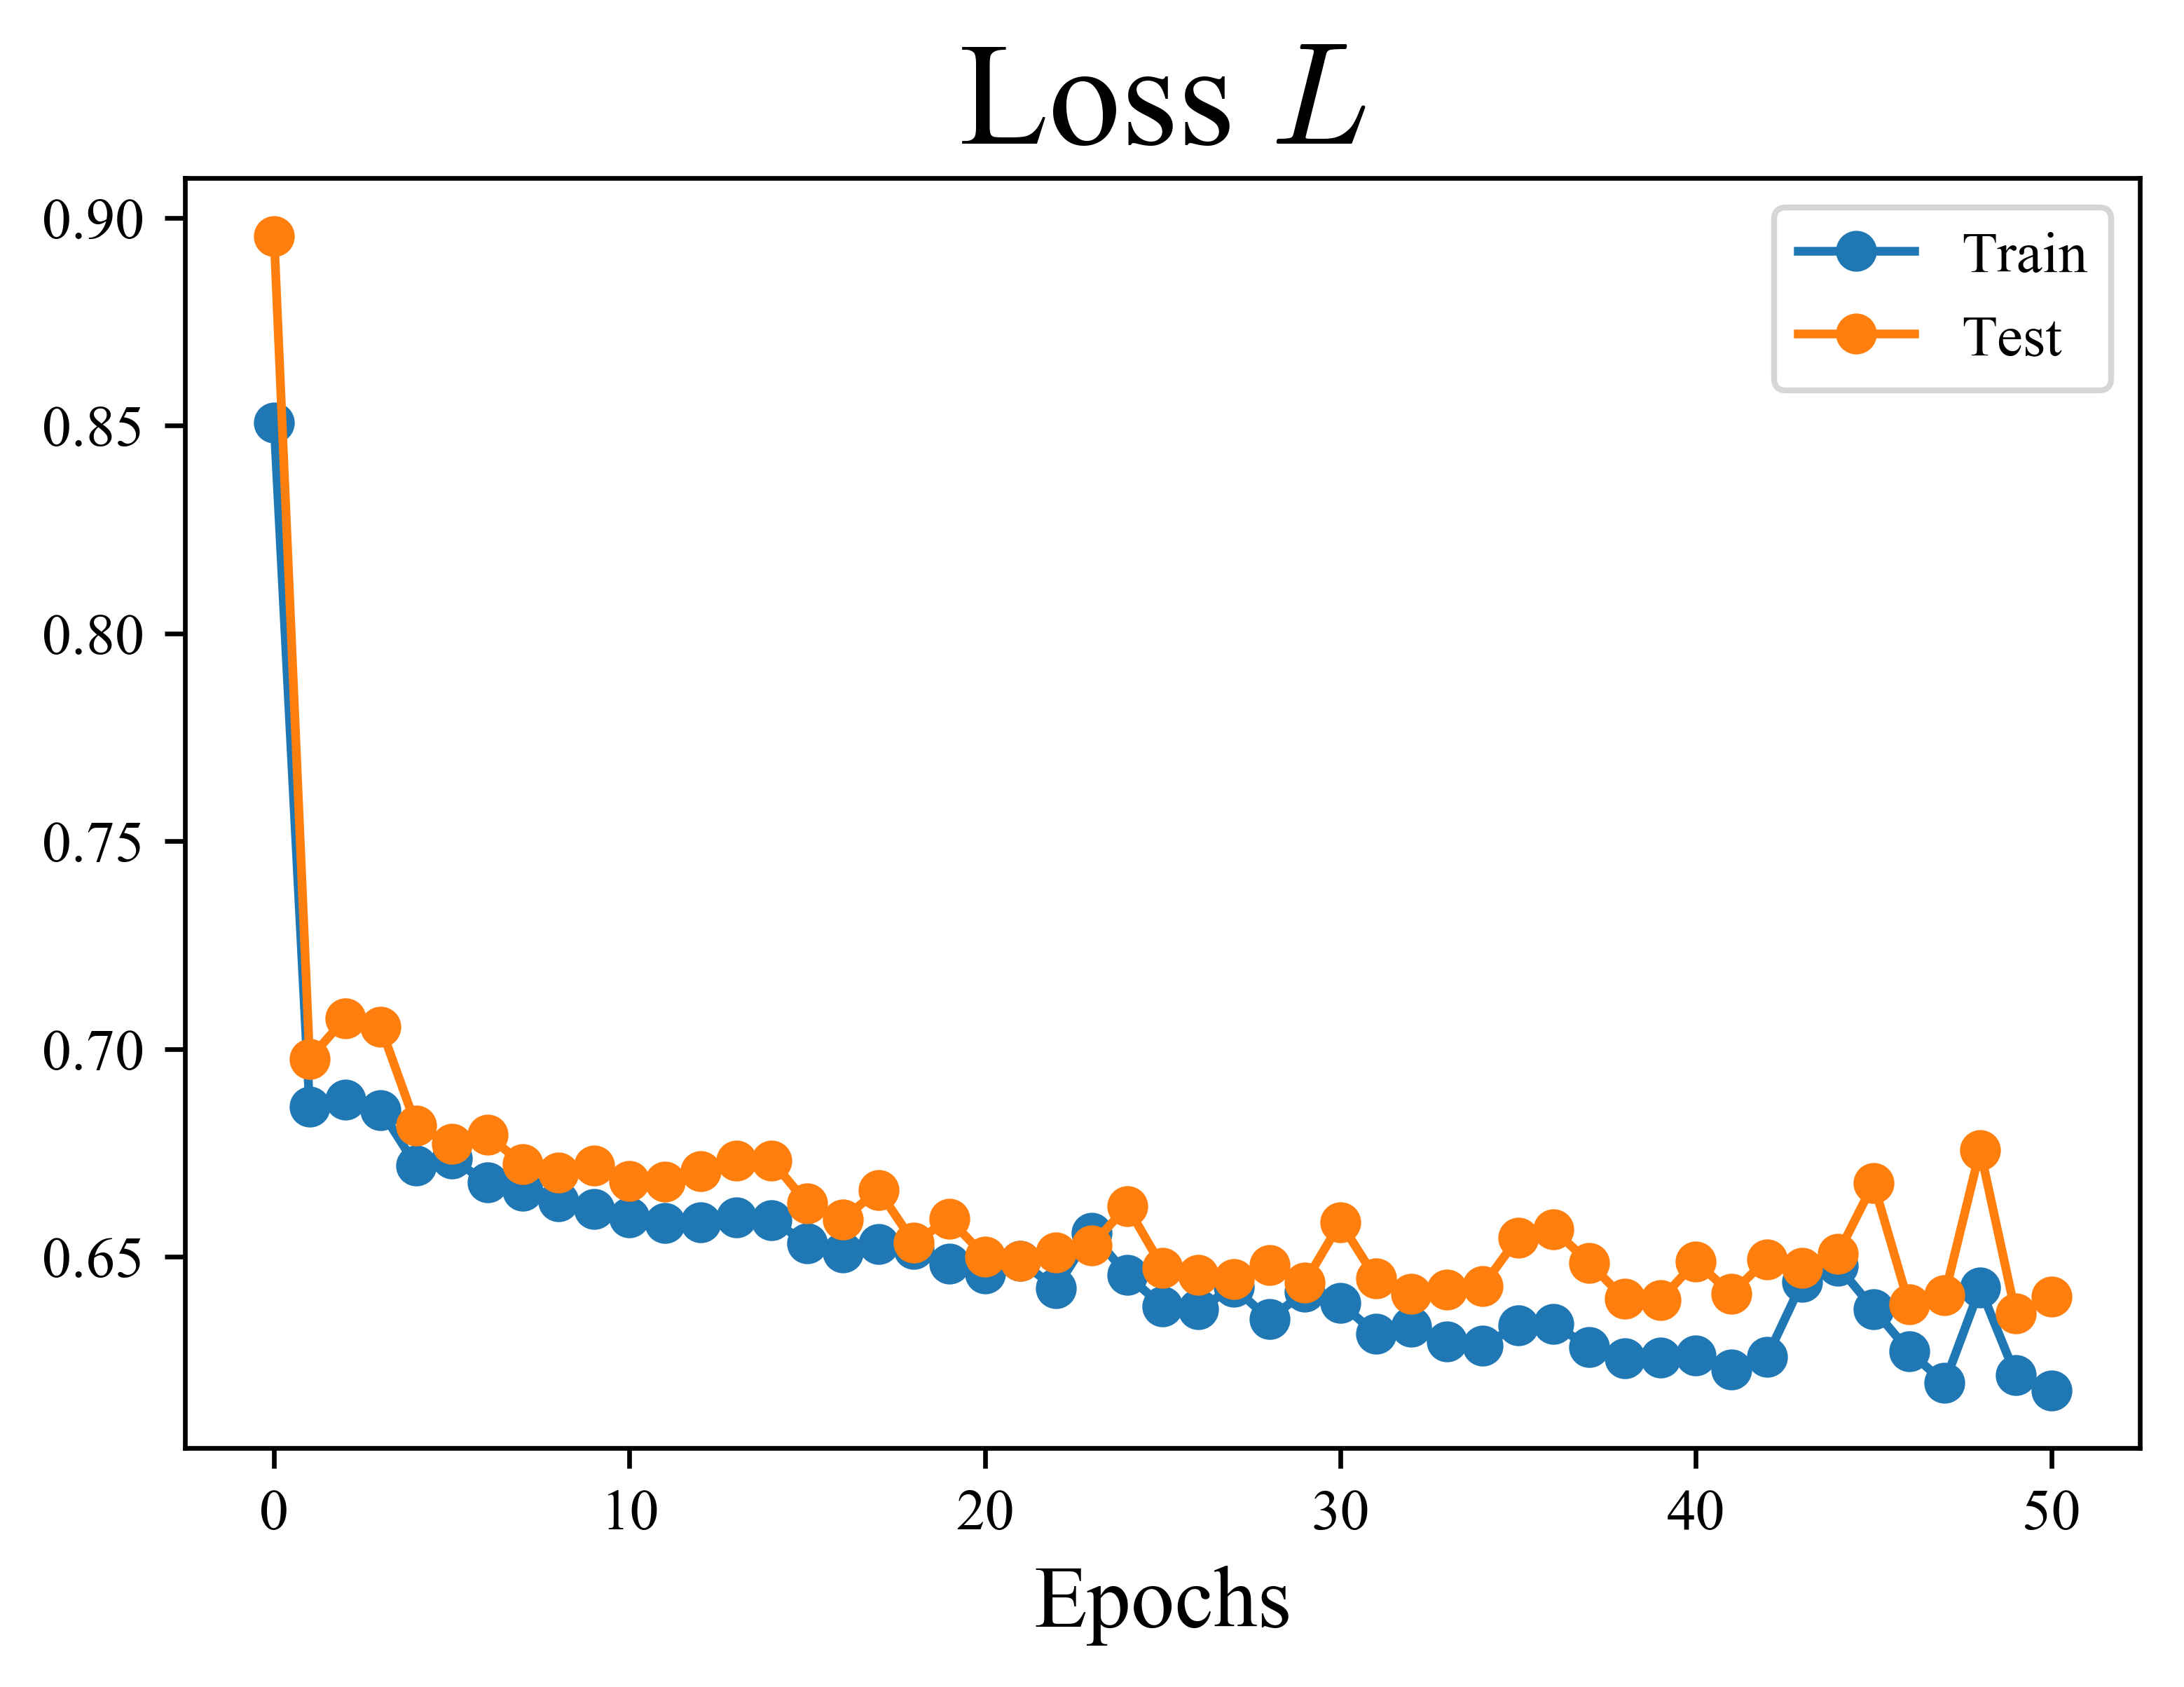

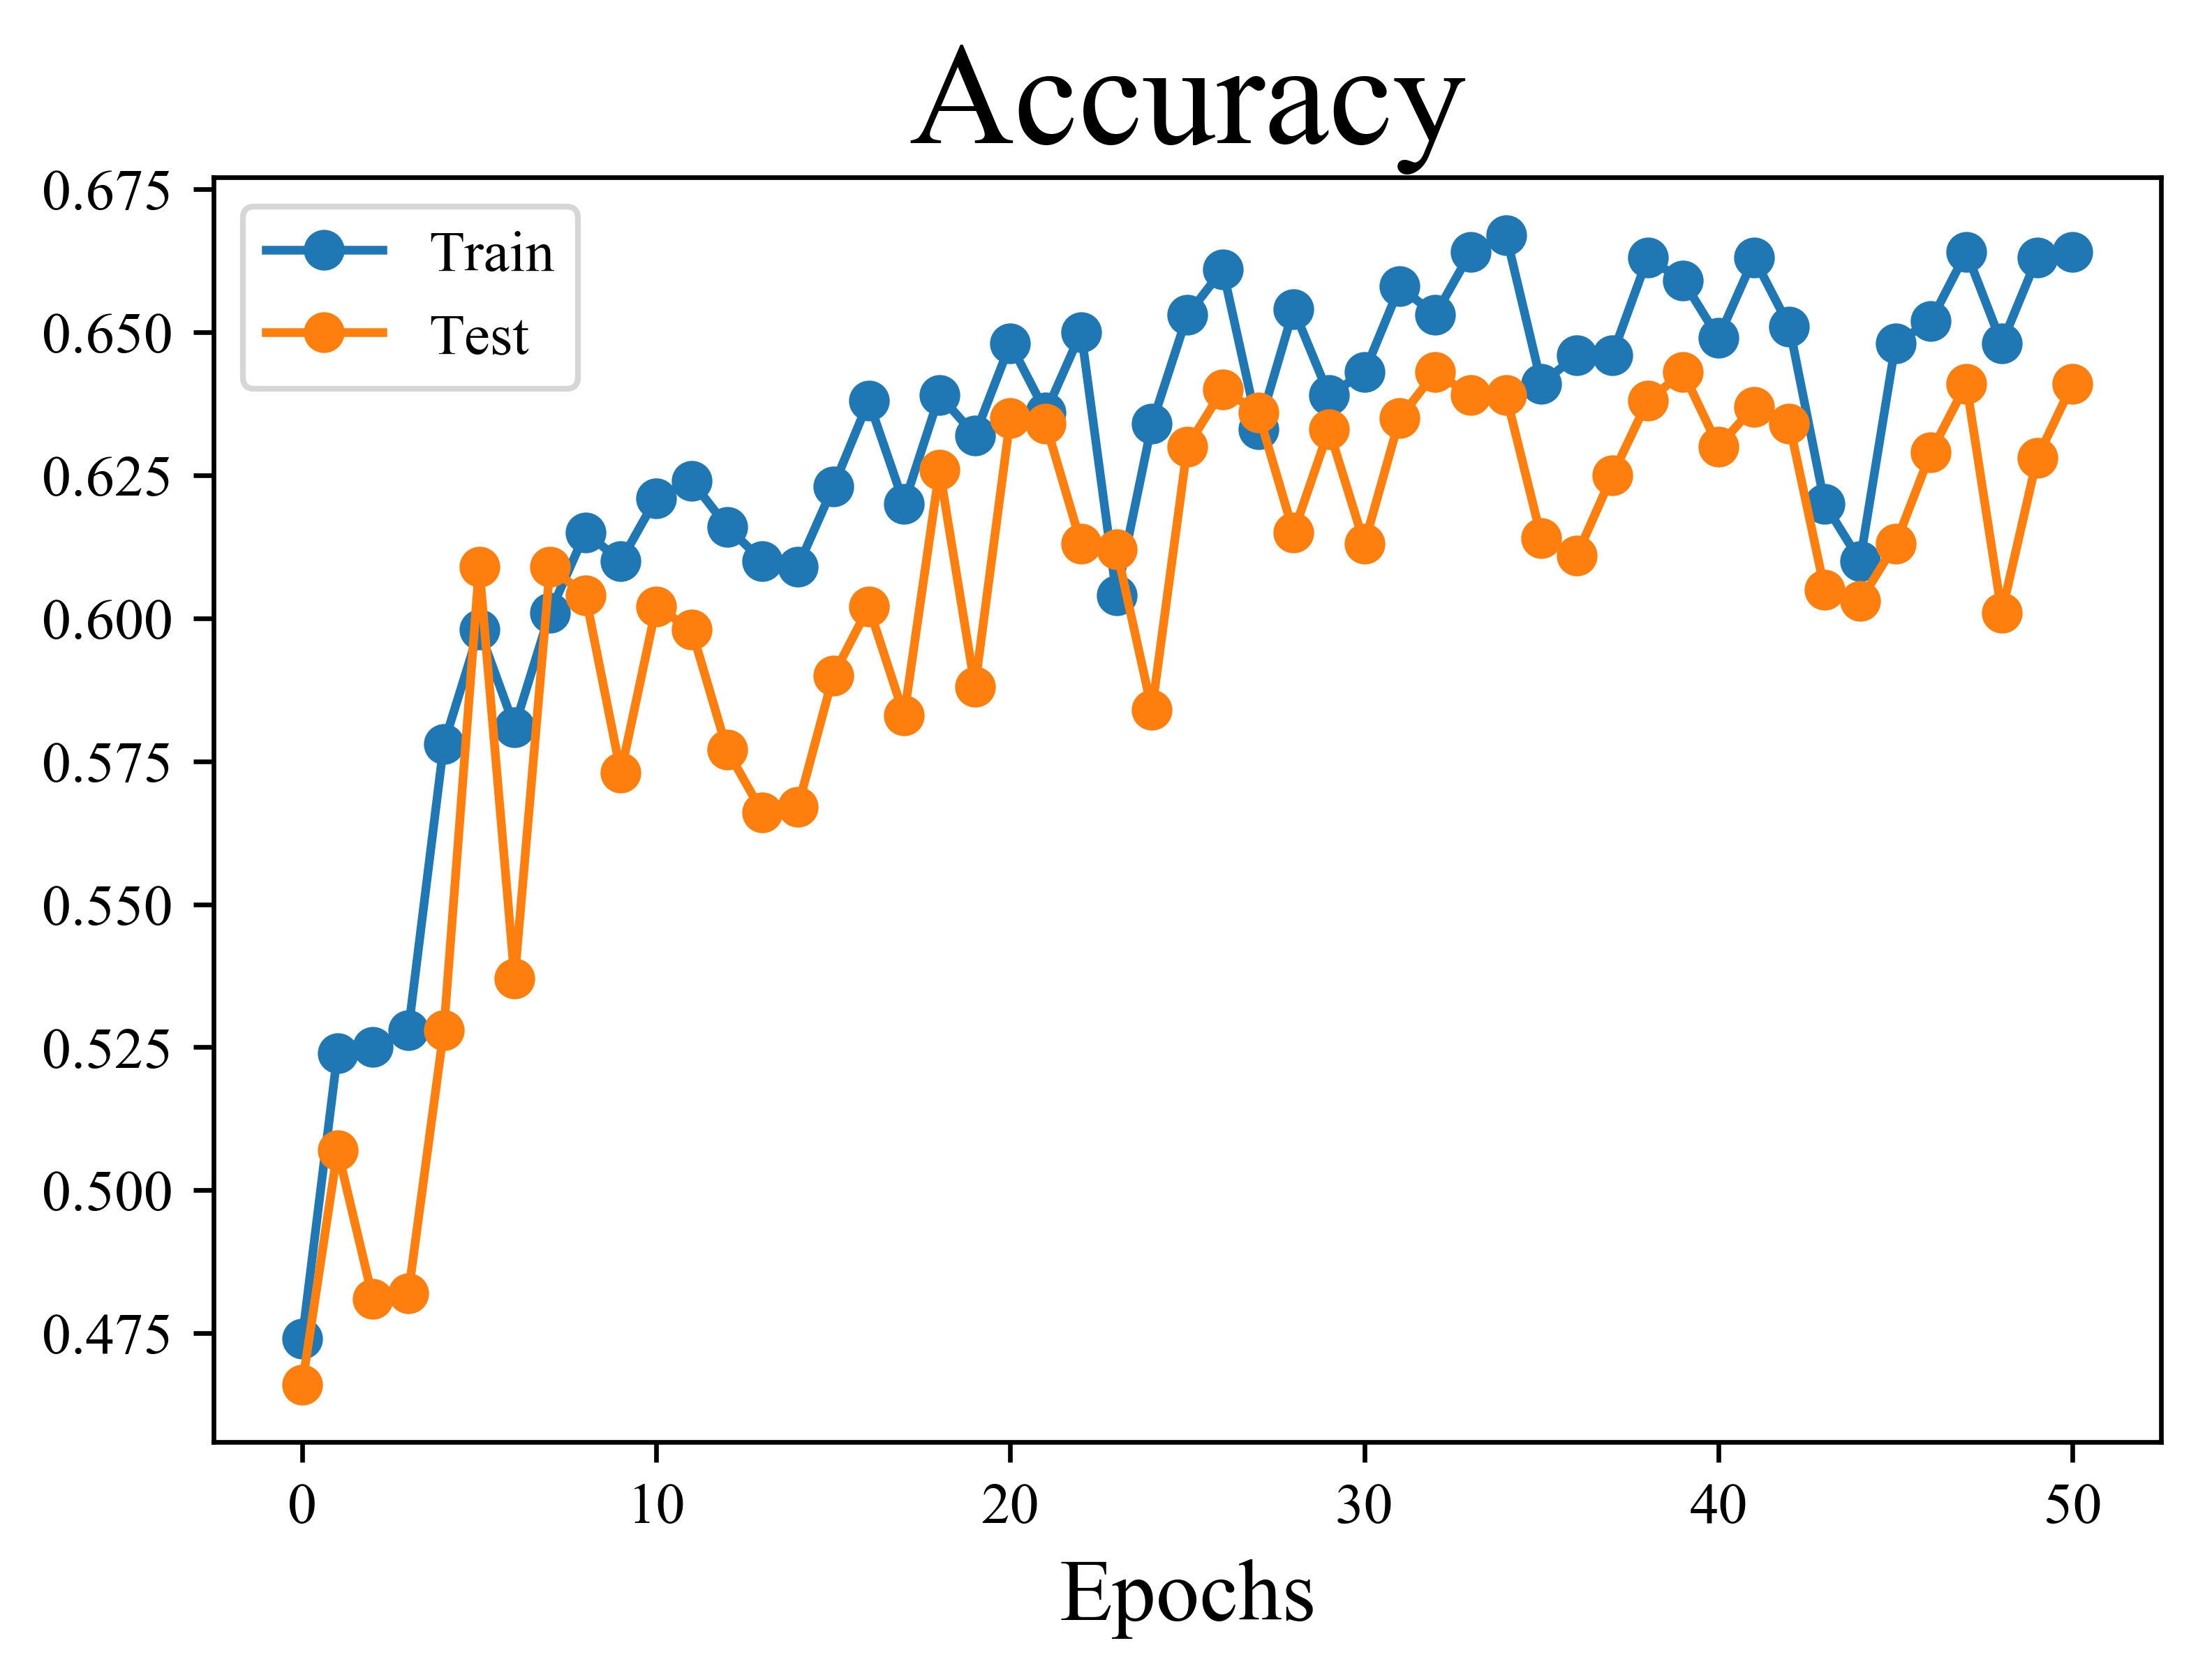

In [108]:
epsilon = 0.001
alpha = 0.001
eta = 0.9

# GNNのインスタンス生成
n_1 = GNN_MomentumSGD(alpha, epsilon)
n_1.W = np.array([[-2.52692808e-03,  2.92991035e-02,  5.67734735e-01, -4.25723553e-01, -1.36768259e-01, -3.61743362e-01, -8.17870662e-02,  3.73247119e-01],
                  [1.31089595e-02,  9.86127673e-02,  5.63567778e-05,  2.57001919e-01, 8.29995460e-01, -2.61330477e-01, -1.25492834e-01,  7.98894435e-02],
                  [-3.95713567e-01, -6.76726032e-01, -4.70752429e-01,  1.08178818e-01, -1.54971447e-01,  8.49478508e-01,  3.46967387e-02,  2.60424736e-01],
                  [-1.87265862e-01,  2.91553243e-01, -3.57373077e-01,  3.61584655e-01, -6.34358457e-02, -4.10927688e-01, -1.79272445e-01, -1.05599351e-01],
                  [-9.44209006e-01, -3.66578331e-01,  2.55020317e-01, -4.91308328e-01, 4.77561246e-01, -2.94744515e-01,  3.40336933e-03, -4.74844518e-01],
                  [3.83720321e-02, -1.00053689e+00, -3.29523178e-01,  1.61176760e-01,  4.60662881e-01, -6.40903355e-01, -6.35938286e-01,  2.99949703e-01],
                  [9.41320367e-01,  3.71874538e-01, -1.42864456e-01,  1.68296016e-01, -1.36711930e-01, -1.13083437e-01,  1.04520881e-01, -2.82616428e-01],
                  [2.84867666e-01,  1.03741936e-01, -5.12851503e-01,  7.65731388e-01, -1.25117393e-01,  5.74013842e-01, -2.61588672e-01, -3.66174601e-01]])
n_1.A = np.array([0.26510168, -0.01441418, 0.60813924, -0.16606723, -0.14615845, 0.0454674, -0.1699852, 0.00942905])

# 学習開始
Learning(n_1, flag=1)

# 課題4
- パラメータ更新アルゴリズムとして、Adamを実装

In [48]:
class GNN_Adam:
    
    def __init__(self, alpha, epsilon, beta_1, beta_2):
        # 集約step数 T, 特徴ベクトル次元 D の設定
        self.T = 2
        self.D = 8
        
        # ハイパーパラメータの設定 (W,Aはランダムサンプリングfrom正規分布)
        self.W = np.random.normal(0.0,0.4,(self.D,self.D))
        self.A = np.random.normal(0.0,0.4,self.D)
        self.b = 0.0
        
        # 移動指数平均m,vの初期化
        self.m_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        self.m_A = np.array([0.0 for i in range(len(self.A))])
        self.m_b = 0.0
        self.v_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        self.v_A = np.array([0.0 for i in range(len(self.A))])
        self.v_b = 0.0
        
        # 微分計算用の微小量 ε
        self.epsilon = epsilon
        # 学習率 α
        self.alpha = alpha
        # β1,β2
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        # step数
        self.t = 1
     

    # 特徴量ベクトルh_Gを作成するFeature_vec関数。引数としてグラフデータG(隣接行列形式)と初期特徴ベクトル集合vecを与える。
    def Feature_vec(self, G, vec):
        
        # 1ステップの集約操作を行うCombine関数、Readout操作を行うReadout関数を定義
        def Combine(G, vec):
            A = np.empty((0,self.D), float)
            for i in range(len(G)):
                # 集約-1
                a = np.array([0.0 for k in range(self.D)])
                for j in range(len(G)):
                    a += G[i][j]*vec[j]
                # 集約-2
                x = Relu(np.dot(self.W,a))
                # 次の特徴ベクトル集合にappend
                A = np.append(A, [x], axis=0)
            return A
        
        def Readout(V):
            h_G = np.zeros(len(V[0]))
            for i in range(len(V)):
                h_G += V[i]
            return h_G
        
        # T回のCombine関数実行後、Readout関数で和を取る
        for step in range(self.T):
            vec = Combine(G, vec)
        return Readout(vec)
    
    
    # 誤差関数
    def Loss(self, G, y, vec):
        # まずFeature_vec関数から特徴ベクトルh_Gを生成。
        h_G = self.Feature_vec(G, vec)
        
        # ラベルyとの差分からbinary cross-entropy損失関数を計算
        s = np.dot(self.A, h_G) + self.b  # s = A・h_G + b
        if (s>=40):                       # sの絶対値が大きい場合は log(1+e^s) ~ s で近似
            L = (1-y)*s
        elif (s<=-40):
            L = y*(-s)
        else:
            L = y*math.log(1+math.exp(-s)) + (1-y)*math.log(1+math.exp(s))
        return L

        
    # ミニバッチサイズB個の(input,label)に対してLoss関数の微分値平均計算、Hyperparametersを更新する
    def train(self, input_list, label_list):
        # 配列の初期化
        mean_diff_W = np.array([[0.0 for i in range(self.D)] for j in range(self.D)])
        mean_diff_A = np.array([0.0 for i in range(len(self.A))])
        mean_diff_b = 0.0
        
        # 各(input,label)についてLossと微分値計算
        for index in range(len(input_list)):
            graph = input_list[index]
            y = label_list[index]
            
            #print("A :", self.A)
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            #print("Loss :", L_now)
            
            # Loss微分値計算
            # Wについて
            diff_W = []
            for j in range(self.D):
                for k in range(self.D):
                    self.W[j][k] += 1.0*self.epsilon
                    diff_W.append(self.Loss(graph, y, vec) - L_now)
                    self.W[j][k] -= 1.0*self.epsilon
            diff_W = np.array(diff_W).reshape(self.D, self.D)
            mean_diff_W += diff_W
            
            # Aについて
            diff_A = []
            for i in range(len(self.A)):
                self.A[i] += 1.0*self.epsilon
                diff_A.append(self.Loss(graph, y, vec) - L_now)
                self.A[i] -= 1.0*self.epsilon
            diff_A = np.array(diff_A)
            mean_diff_A += diff_A
                
            # bについて
            self.b += 1.0*self.epsilon
            diff_b = self.Loss(graph, y, vec) - L_now
            self.b -= 1.0*self.epsilon
            mean_diff_b += diff_b
            
        # Loss微分の平均取る
        mean_diff_W /= len(input_list)*self.epsilon
        mean_diff_A /= len(input_list)*self.epsilon
        mean_diff_b /= len(input_list)*self.epsilon
        #print("mean_diff_A :", mean_diff_A)
        
        # バイアス消去
        self.m_W = self.beta_1*self.m_W + (1-self.beta_1)*mean_diff_W
        self.m_A = self.beta_1*self.m_A + (1-self.beta_1)*mean_diff_A
        self.m_b = self.beta_1*self.m_b + (1-self.beta_1)*mean_diff_b
        self.v_W = self.beta_2*self.v_W + (1-self.beta_2)*(mean_diff_W**2)
        self.v_A = self.beta_2*self.v_A + (1-self.beta_2)*(mean_diff_A**2)
        self.v_b = self.beta_2*self.v_b + (1-self.beta_2)*(mean_diff_b**2)
        
        # パラメータ更新
        self.W += -self.alpha*(self.m_W/(1-self.beta_1**self.t))/(np.sqrt(self.v_W/(1-self.beta_2**self.t)) + 0.00000001)
        self.A += -self.alpha*(self.m_A/(1-self.beta_1**self.t))/(np.sqrt(self.v_A/(1-self.beta_2**self.t)) + 0.00000001)
        self.b += -self.alpha*(self.m_b/(1-self.beta_1**self.t))/(np.sqrt(self.v_b/(1-self.beta_2**self.t)) + 0.00000001)
        
        
    def test(self, input_list, label_list):
        # 配列の初期化
        Loss_list = []
        s_list = []
        
        # 各(input,label)についてLoss計算
        for index in range(len(input_list)):
            graph = input_list[index]
            y = label_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # Loss(graph,y)関数計算
            L_now = self.Loss(graph, y, vec)
            Loss_list.append(L_now)
            
            # s値計算
            s_list.append(np.dot(self.A, self.Feature_vec(graph, vec)) + self.b)

        
        # 平均損失と正答率を計算
        true = 0
        for i in range(len(input_list)):
            #print(s_list[i], label_list[i])
            if (s_list[i]>0.0 and label_list[i]==1):
                true += 1
            elif (s_list[i]<=0.0 and label_list[i]==0):
                true += 1
        true /= float(len(input_list))
        Loss_list = np.array(Loss_list)
        return np.mean(Loss_list), true
    
    
    # ラベル無しテストデータに対するs値計算、y予測
    def test_nolabel(self, input_list):
        # 結果保存用配列
        label_list = []
        
        # 各inputについてs値計算
        for index in range(len(input_list)):
            graph = input_list[index]
            
            # 初期vector生成
            vec = np.array([[0.0 for j in range(self.D)] for i in range(len(graph))])
            if (self.D < len(graph)):
                for i in range(self.D):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            else:
                for i in range(len(graph)):
                    if (i%2==0):
                        vec[i][i] = 1.0
                    else:
                        vec[i][i] = -1.0
            
            # s値計算
            s = np.dot(self.A, self.Feature_vec(graph, vec)) + self.b
            
            # ラベル予測
            label = -1
            if (s>0.0):
                label_list.append(1)
            else:
                label_list.append(0)
                
        # ファイル出力
        path = './outputs/'
        with open(path+'prediction.txt', mode='w') as aa:
            for i in range(len(label_list)):
                aa.write(str(label_list[i]))
                aa.write("\n")

In [49]:
# GNNのインスタンスnに対して、train,test,出力を行う
def Learning_Adam(n):
    # エポック数 epochs、ミニバッチサイズ B、訓練データサイズ(検証データサイズ) の設定
    epochs = 50
    B = 10
    datasize_train = 1000
    datasize_test = 2000 - datasize_train
    
    # 結果保持用の配列を初期化
    result_train_loss = []
    result_train_accuracy = []
    result_test_loss = []
    result_test_accuracy = []
    
    # まずは学習前に損失Lと正答率を計算
    temp_loss, temp_accuracy = n.test(graph_data[0:datasize_train], label_data[0:datasize_train])
    result_train_loss.append(temp_loss)
    result_train_accuracy.append(temp_accuracy)
    temp_loss, temp_accuracy = n.test(graph_data[datasize_train:2000], label_data[datasize_train:2000])
    result_test_loss.append(temp_loss)
    result_test_accuracy.append(temp_accuracy)
    print("          (訓練データ)                       (テストデータ)")
    print("平均ロス : {:.3f}".format(result_train_loss[-1]), "正答率 : {:.3f}".format(result_train_accuracy[-1]), ",     平均ロス : {:.3f}".format(temp_loss), "正答率 : {:.3f}".format(temp_accuracy))
    
    # 学習開始
    for epoch in range(epochs):
        # 訓練データをB個ずつのミニバッチにランダム分割
        random_list = np.array([i for i in range(datasize_train)])
        np.random.shuffle(random_list)
        random_list = random_list.reshape(int(datasize_train/B),B)
        
        # 1epochの学習を行う
        for i in range(int(datasize_train/B)):
            mini_batch_graph = []
            mini_batch_label = []
            for j in range(B):
                mini_batch_graph.append(graph_data[random_list[i][j]])
                mini_batch_label.append(label_data[random_list[i][j]])
            n.train(mini_batch_graph, mini_batch_label)
        # 1epoch終了でstep数を+1
        n.t += 1
            
        # 学習後の損失Lと正答率を計算
        temp_loss, temp_accuracy = n.test(graph_data[0:datasize_train], label_data[0:datasize_train])
        result_train_loss.append(temp_loss)
        result_train_accuracy.append(temp_accuracy)
        temp_loss, temp_accuracy = n.test(graph_data[datasize_train:2000], label_data[datasize_train:2000])
        result_test_loss.append(temp_loss)
        result_test_accuracy.append(temp_accuracy)
        print("平均ロス : {:.3f}".format(result_train_loss[-1]), "正答率 : {:.3f}".format(result_train_accuracy[-1]), ",     平均ロス : {:.3f}".format(temp_loss), "正答率 : {:.3f}".format(temp_accuracy))
        
    # ファイル出力
    path = './outputs/GNN_Adam/'
        
    with open(path+'Loss_train.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_train_loss[i]))
            aa.write("\n")
    with open(path+'Loss_test.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_test_loss[i]))
            aa.write("\n")
    with open(path+'Accuracy_train.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_train_accuracy[i]))
            aa.write("\n")
    with open(path+'Accuracy_test.txt', mode='w') as aa:
        for i in range(len(result_train_loss)):
            aa.write(str(result_test_accuracy[i]))
            aa.write("\n")
    with open(path+'Hyperparmeters.txt', mode='w') as aa:
        for i in range(len(n.W)):
            for j in range(len(n.W[i])):
                aa.write(str(n.W[i][j]) + " ")
            aa.write("\n")
        for i in range(len(n.A)):
            aa.write(str(n.A[i]) + " ")
        aa.write("\n")
        aa. write(str(n.b))
    
    # 作図プロット
    plt.figure(dpi=600)
    plt.xlabel("Epochs",fontsize=15)
    plt.title('Loss $\it{L}$',loc='center',fontsize=25)
    plt.plot(result_train_loss,'o-',label="Train")
    plt.plot(result_test_loss,'o-', label="Test")
    plt.legend()
    plt.show()
    
    plt.figure(dpi=600)
    plt.xlabel("Epochs",fontsize=15)
    plt.title('Accuracy',loc='center',fontsize=25)
    plt.plot(result_train_accuracy,'o-',label="Train")
    plt.plot(result_test_accuracy,'o-', label="Test")
    plt.legend()
    plt.show()

          (訓練データ)                       (テストデータ)
平均ロス : 2.103 正答率 : 0.516 ,     平均ロス : 2.224 正答率 : 0.474
平均ロス : 0.792 正答率 : 0.516 ,     平均ロス : 0.818 正答率 : 0.517
平均ロス : 0.743 正答率 : 0.534 ,     平均ロス : 0.768 正答率 : 0.521
平均ロス : 0.717 正答率 : 0.548 ,     平均ロス : 0.744 正答率 : 0.509
平均ロス : 0.700 正答率 : 0.543 ,     平均ロス : 0.721 正答率 : 0.534
平均ロス : 0.690 正答率 : 0.548 ,     平均ロス : 0.710 正答率 : 0.533
平均ロス : 0.681 正答率 : 0.559 ,     平均ロス : 0.703 正答率 : 0.539
平均ロス : 0.675 正答率 : 0.565 ,     平均ロス : 0.696 正答率 : 0.550
平均ロス : 0.670 正答率 : 0.569 ,     平均ロス : 0.691 正答率 : 0.557
平均ロス : 0.666 正答率 : 0.572 ,     平均ロス : 0.686 正答率 : 0.557
平均ロス : 0.663 正答率 : 0.559 ,     平均ロス : 0.686 正答率 : 0.560
平均ロス : 0.660 正答率 : 0.576 ,     平均ロス : 0.682 正答率 : 0.570
平均ロス : 0.658 正答率 : 0.573 ,     平均ロス : 0.680 正答率 : 0.571
平均ロス : 0.655 正答率 : 0.577 ,     平均ロス : 0.678 正答率 : 0.574
平均ロス : 0.653 正答率 : 0.585 ,     平均ロス : 0.675 正答率 : 0.581
平均ロス : 0.650 正答率 : 0.597 ,     平均ロス : 0.676 正答率 : 0.582
平均ロス : 0.648 正答率 : 0.599 ,     平均ロス : 0.672 正答率 : 0.595

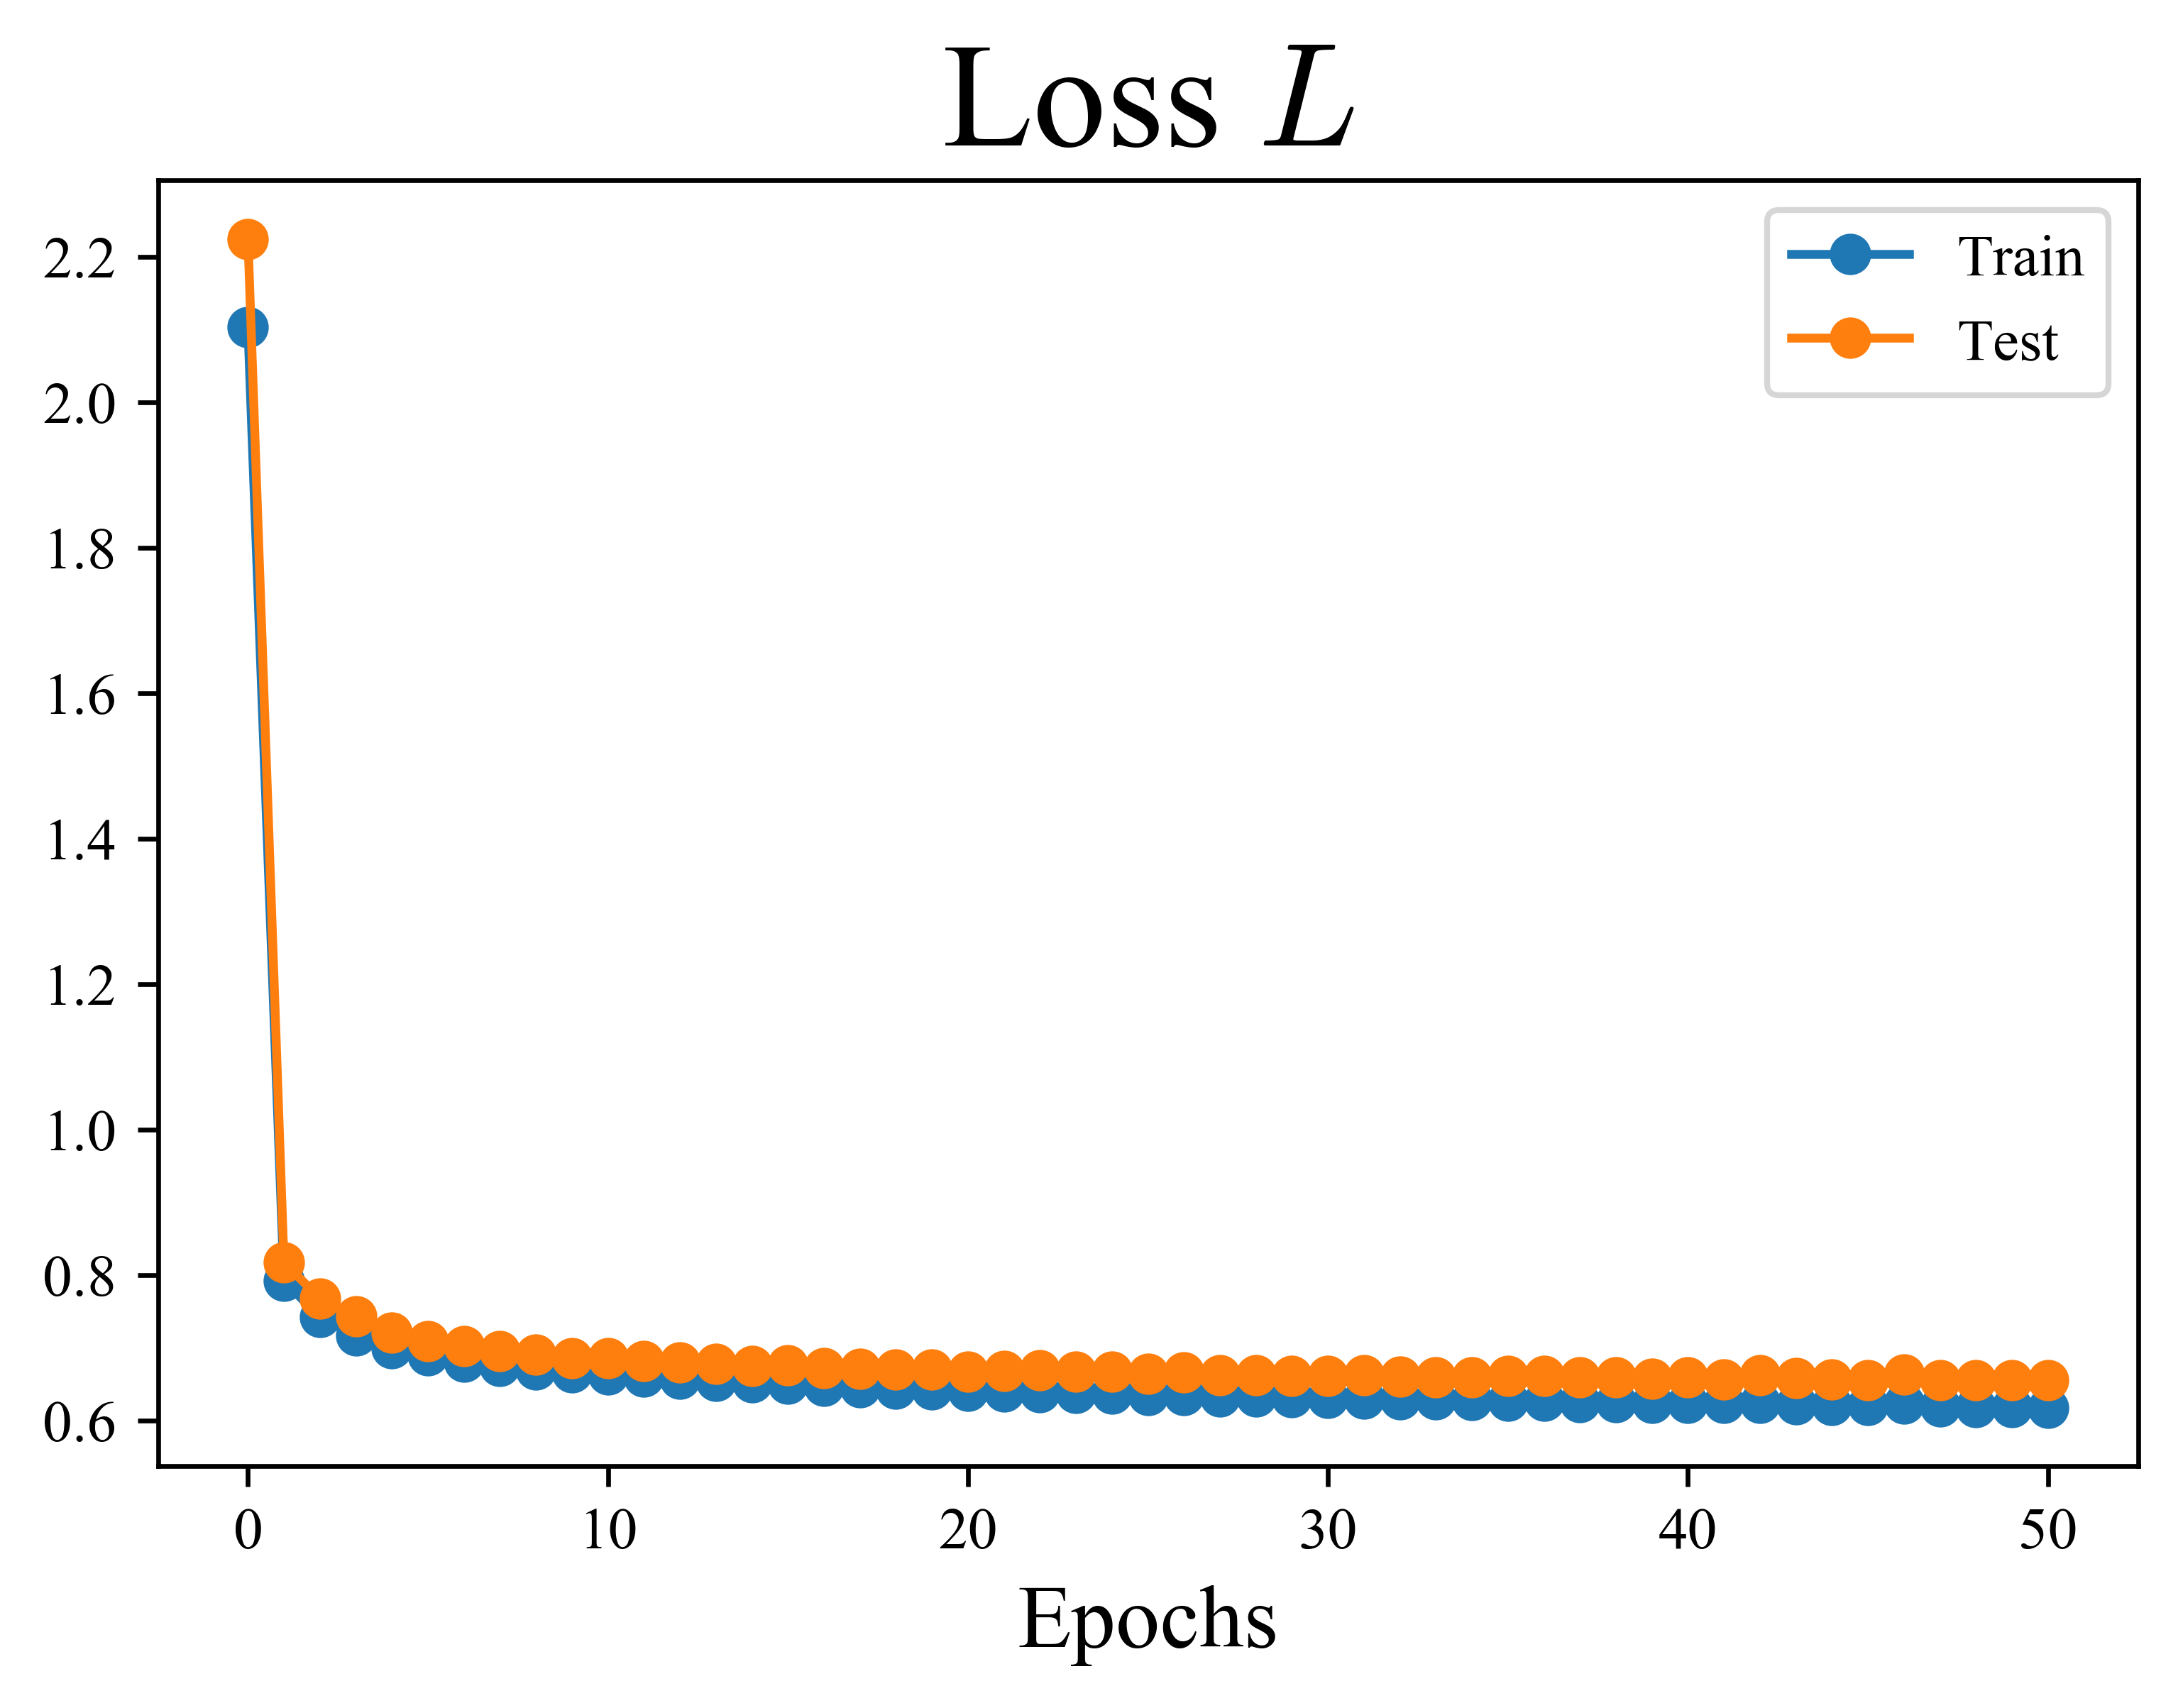

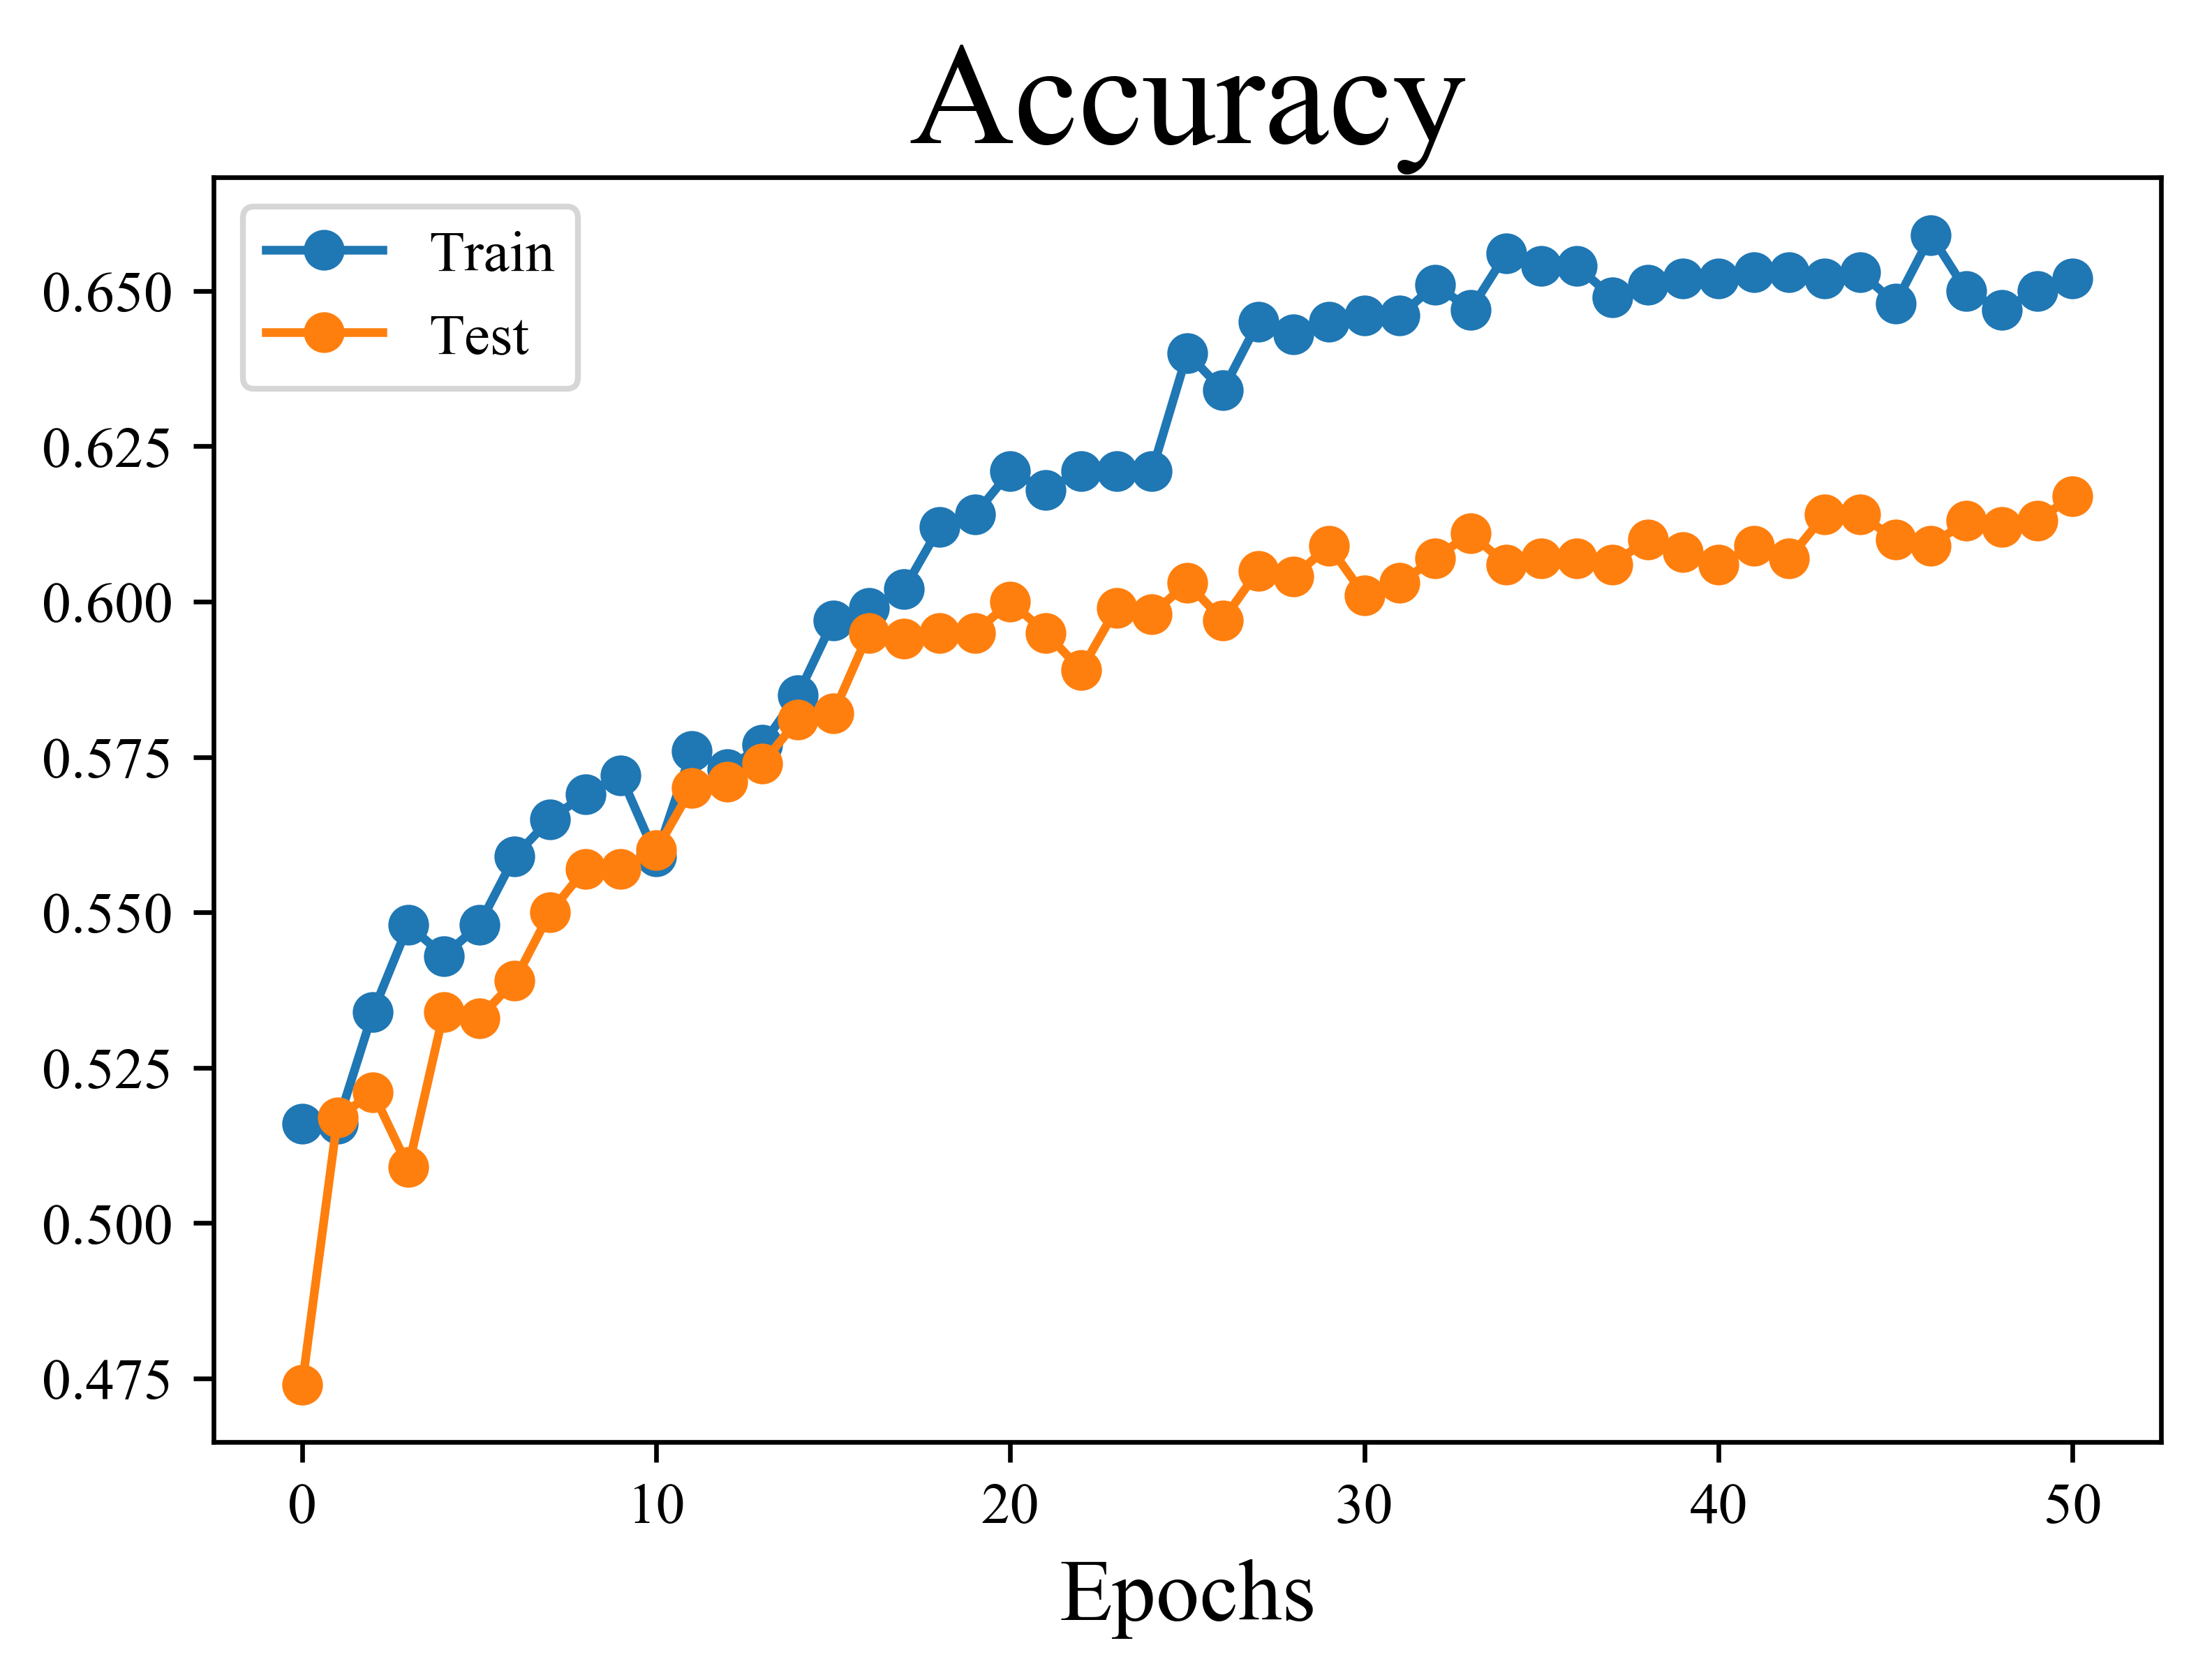

In [50]:
epsilon = 0.001
alpha = 0.001
beta_1 = 0.9
beta_2 = 0.99

# GNNのインスタンス生成
n_2 = GNN_Adam(alpha, epsilon, beta_1, beta_2)

# 学習開始
Learning_Adam(n_2)

### ラベル予測

In [110]:
# グラフデータとラベルデータを格納する配列を定義
graph_data_test = []

# テキストファイルの読み込み
for i in range(500):
    graph_temp = []
    D = 0
    path = './datasets/test/' + str(i) + '_graph.txt' 
    file_data = open(path, "r")
    for line in file_data:
        temp = line.strip()
        temp = temp.split()
        if (len(temp)==1):
            D = int(temp[0])
        if (len(temp)!=1):
            for j in range(D):
                graph_temp.append(int(temp[j]))
    file_data.close()
    graph_temp = np.array(graph_temp).reshape(D,D)
    graph_data_test.append(graph_temp)

In [57]:
# ラベル無しテストデータに対する予測
n_2.test_nolabel(graph_data_test)